In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

# Data

In [5]:
velocity = 0.1

In [6]:
# Read data
motion = np.genfromtxt('../dataset3/motion_01_stutter.csv', delimiter=',', dtype=np.float64)
print("Motion data has a length of ", len(motion))

Motion data has a length of  4767


In [7]:
# Find idx of motion correspondant to 0.1
idx_motion_01 = []
for idx, row in enumerate(motion):
    if any(abs(item) == velocity for item in row[1:7]):
        idx_motion_01.append(idx)
        
motion_01 = motion[idx_motion_01]

In [8]:
motion_01.shape

(4767, 40)

## Visualizations

In [9]:
"""
    Plot a 4x2 grid of comparing data.
"""
def plot_non_overlapping_data(dataset, data:list, idxs: list):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(20,15))
    fig.suptitle('Heigh-Force (Idle)')

    ax1.plot(dataset[data[0], 0], dataset[data[0], idxs[0]], 'b-')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Height (FL)')

    ax2.plot(dataset[data[0], 0], dataset[data[0], idxs[1]], 'g-')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Force (FL)')

    ax3.plot(dataset[data[1], 0], dataset[data[1], idxs[2]], 'b-')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Height (FR)')

    ax4.plot(dataset[data[1], 0], dataset[data[1], idxs[3]], 'g-')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('Force (FR)')

    ax5.plot(dataset[data[2], 0], dataset[data[2], idxs[4]], 'b-')
    ax5.set_xlabel('Time')
    ax5.set_ylabel('Height (RL)')

    ax6.plot(dataset[data[2], 0], datasetD[data[2], idxs[5]], 'g-')
    ax6.set_xlabel('Time')
    ax6.set_ylabel('Force (RL)')

    ax7.plot(dataset[data[3], 0], dataset[data[3], idxs[6]], 'b-')
    ax7.set_xlabel('Time')
    ax7.set_ylabel('Height (RR)')

    ax8.plot(dataset[data[3], 0], dataset[data[3], idxs[7]], 'g-')
    ax8.set_xlabel('Time')
    ax8.set_ylabel('Force (RR)')

    fig.tight_layout()

    plt.show()
 
"""
    Plot data on overlapping graph. 
"""
def plot_overlapping_data(title: str, dataset, data: list, idxs: list, draw_footsteps=None, footsteps_timestamp=None):
    fig, (ax1, ax3, ax5, ax7) = plt.subplots(4,1, figsize=(20,15))
    fig.suptitle(title)
    
    # FL plot (height)
    ax1.plot(dataset[data[0], 0], dataset[data[0], idxs[0]], 'b-')
    ax1.set_ylabel('Height (FL)', color='b')
    ax1.set_xlabel('Time')
         
    # FL plot (force)
    ax2 = ax1.twinx()
    ax2.plot(dataset[data[0], 0], dataset[data[0], idxs[1]], 'g-')
    ax2.set_ylabel('Force (FL)', color='g')
          
    # FR plot (height)
    ax3.plot(dataset[data[1], 0], dataset[data[1], idxs[2]], 'b-')
    ax3.set_ylabel('Height (FR)', color='b')
    ax3.set_xlabel('Time')
         
    # FR plot (force)
    ax4 = ax3.twinx()
    ax4.plot(dataset[data[1], 0], dataset[data[1], idxs[3]], 'g-')
    ax4.set_ylabel('Force(FR)', color='g')      
          
    # RL plot (height)
    ax5.plot(dataset[data[2], 0], dataset[data[2], idxs[4]], 'b-')
    ax5.set_ylabel('Height (RL)', color='b')
    ax5.set_xlabel('Time')
         
    # RL plot (force)
    ax6 = ax5.twinx()
    ax6.plot(dataset[data[2], 0], dataset[data[2], idxs[5]], 'g-')
    ax6.set_ylabel('Force (RL)', color='g')   
          
    # RR plot (height)
    ax7.plot(dataset[data[3], 0], dataset[data[3], idxs[6]], 'b-')
    ax7.set_ylabel('Height (RR)', color='b')
    ax7.set_xlabel('Time')
         
    # RR plot (force)
    ax8 = ax7.twinx()
    ax8.plot(dataset[data[3], 0], dataset[data[3], idxs[7]], 'g-')
    ax8.set_ylabel('Force (RR)', color='g')

    for ax in [ax2, ax4, ax6, ax8]:
        for tl in ax.get_yticklabels():
            tl.set_color('g')
    
    for ax in [ax1, ax3, ax5, ax7]:
        for tl in ax.get_yticklabels():
            tl.set_color('b')
    
    # Draw footsteps
    if draw_footsteps:
        for ax in [ax1, ax3, ax5, ax7]:
            for footstep_timestamp in footsteps_timestamp:
                if footstep_timestamp <= max(dataset[data[0], 0]) and footstep_timestamp >= min(dataset[data[0], 0]):
                    #print("Timestamp: ", footstep_timestamp)
                    ax.axvline(x=footstep_timestamp, color='r', linestyle='-')
                    #ax.axvline(x=footstep_timestamp+0.15, color='b', linestyle='-')
    
    fig.tight_layout()
    plt.show()

## Height-Force plots

In [10]:
def get_specific_cmd(dataset, fwd, side, rot):
    idxs = []
    for row_id, item in enumerate(motion_01):
        if np.isclose(item[1], fwd, 0.01) and np.isclose(item[2], side, 0.01) and np.isclose(item[6], rot, 0.01):
            idxs.append(row_id)
    
    return idxs

In [11]:
def get_swinging_motions(dataset, height=-0.1):
    # FR min height (i.e swining motion)
    fr_min_height = np.where(dataset[:, 9] < height)[0]
    fl_min_height = np.where(dataset[:, 12] < height)[0]
    rr_min_height = np.where(dataset[:, 15] < height)[0]
    rl_min_height = np.where(dataset[:, 18] < height)[0]
            
    return fr_min_height,fl_min_height,rr_min_height,rl_min_height

## Motion_01

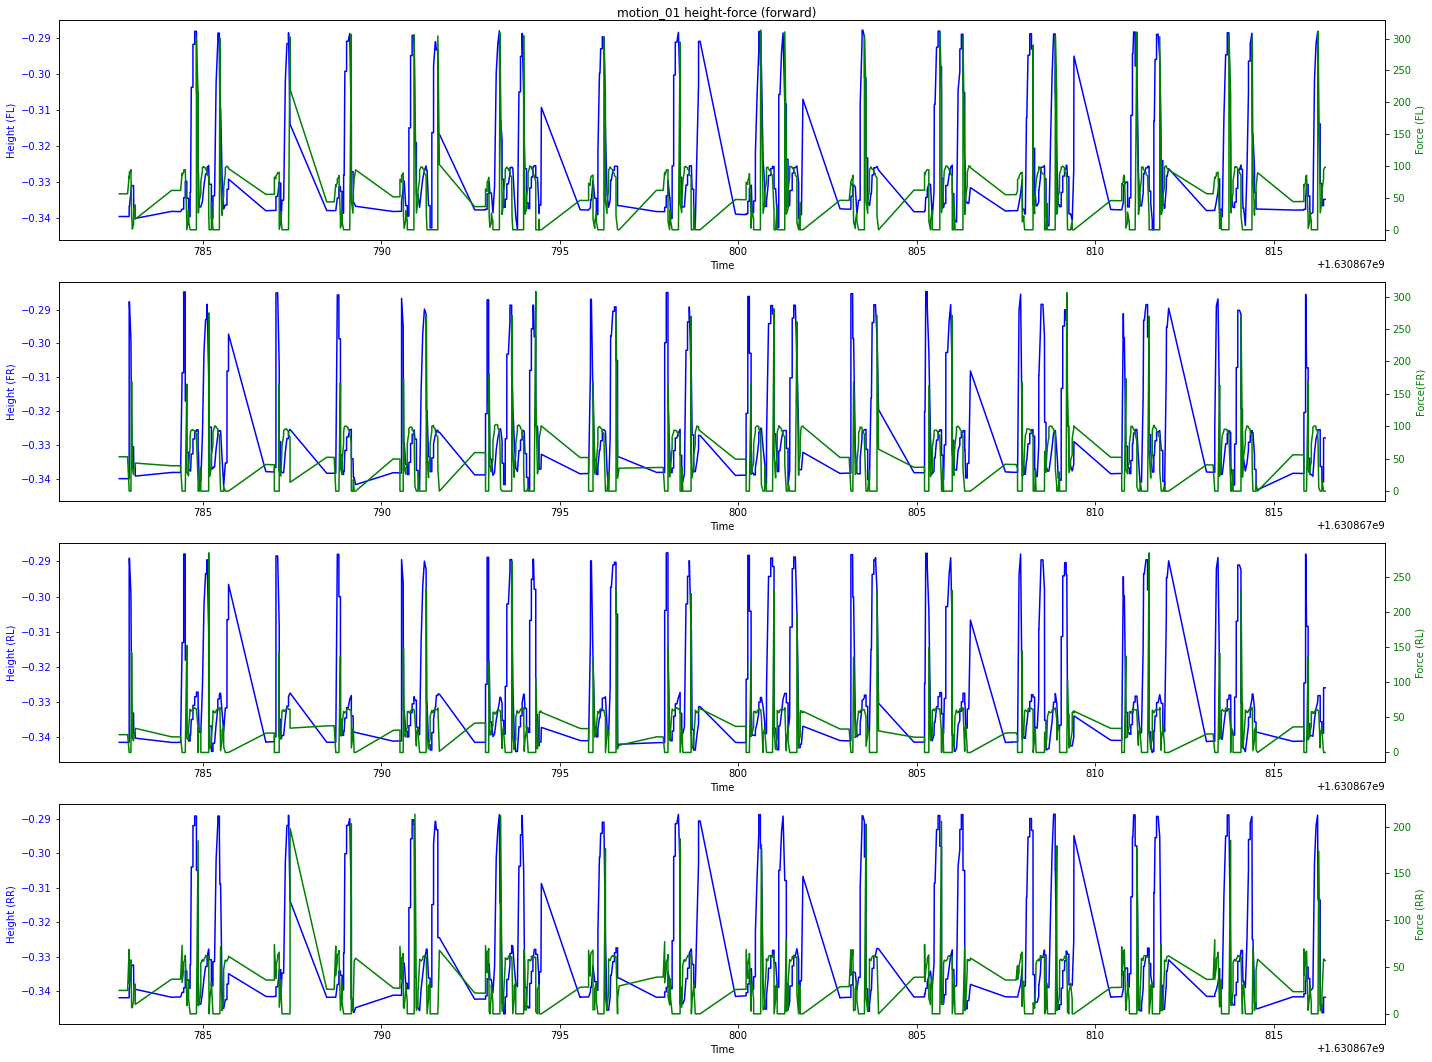

In [12]:
# Forward
fwd_cmds = get_specific_cmd(motion_01, velocity, 0, 0)
motion_01_fwd = motion_01[fwd_cmds]
fr_min_height,fl_min_height,rr_min_height,rl_min_height = get_swinging_motions(motion_01_fwd)

sample_walking_fr_height = fr_min_height
sample_walking_fl_height = fl_min_height
sample_walking_rr_height = rr_min_height
sample_walking_rl_height = rl_min_height

plot_overlapping_data("motion_01 height-force (forward)",
                      motion_01,
                      [sample_walking_fr_height, 
                       sample_walking_fl_height, 
                       sample_walking_rr_height,
                       sample_walking_rl_height],
                       [9, 21, 12, 24, 15, 27, 18, 30])

In [15]:
"""
# Backwards
bwd_cmds = get_specific_cmd(motion_01, -velocity, 0, 0)
motion_01_bwd = motion_01[bwd_cmds]
fr_min_height,fl_min_height,rr_min_height,rl_min_height = get_swinging_motions(motion_01_bwd)

sample_walking_fr_height = fr_min_height
sample_walking_fl_height = fl_min_height
sample_walking_rr_height = rr_min_height
sample_walking_rl_height = rl_min_height

plot_overlapping_data("motion_01 height-force (backward)",
                      motion_01,
                      [sample_walking_fr_height, 
                       sample_walking_fl_height, 
                       sample_walking_rr_height,
                       sample_walking_rl_height],
                       [9, 21, 12, 24, 15, 27, 18, 30])
"""

'\n# Backwards\nbwd_cmds = get_specific_cmd(motion_01, -velocity, 0, 0)\nmotion_01_bwd = motion_01[bwd_cmds]\nfr_min_height,fl_min_height,rr_min_height,rl_min_height = get_swinging_motions(motion_01_bwd)\n\nsample_walking_fr_height = fr_min_height\nsample_walking_fl_height = fl_min_height\nsample_walking_rr_height = rr_min_height\nsample_walking_rl_height = rl_min_height\n\nplot_overlapping_data("motion_01 height-force (backward)",\n                      motion_01,\n                      [sample_walking_fr_height, \n                       sample_walking_fl_height, \n                       sample_walking_rr_height,\n                       sample_walking_rl_height],\n                       [9, 21, 12, 24, 15, 27, 18, 30])\n'

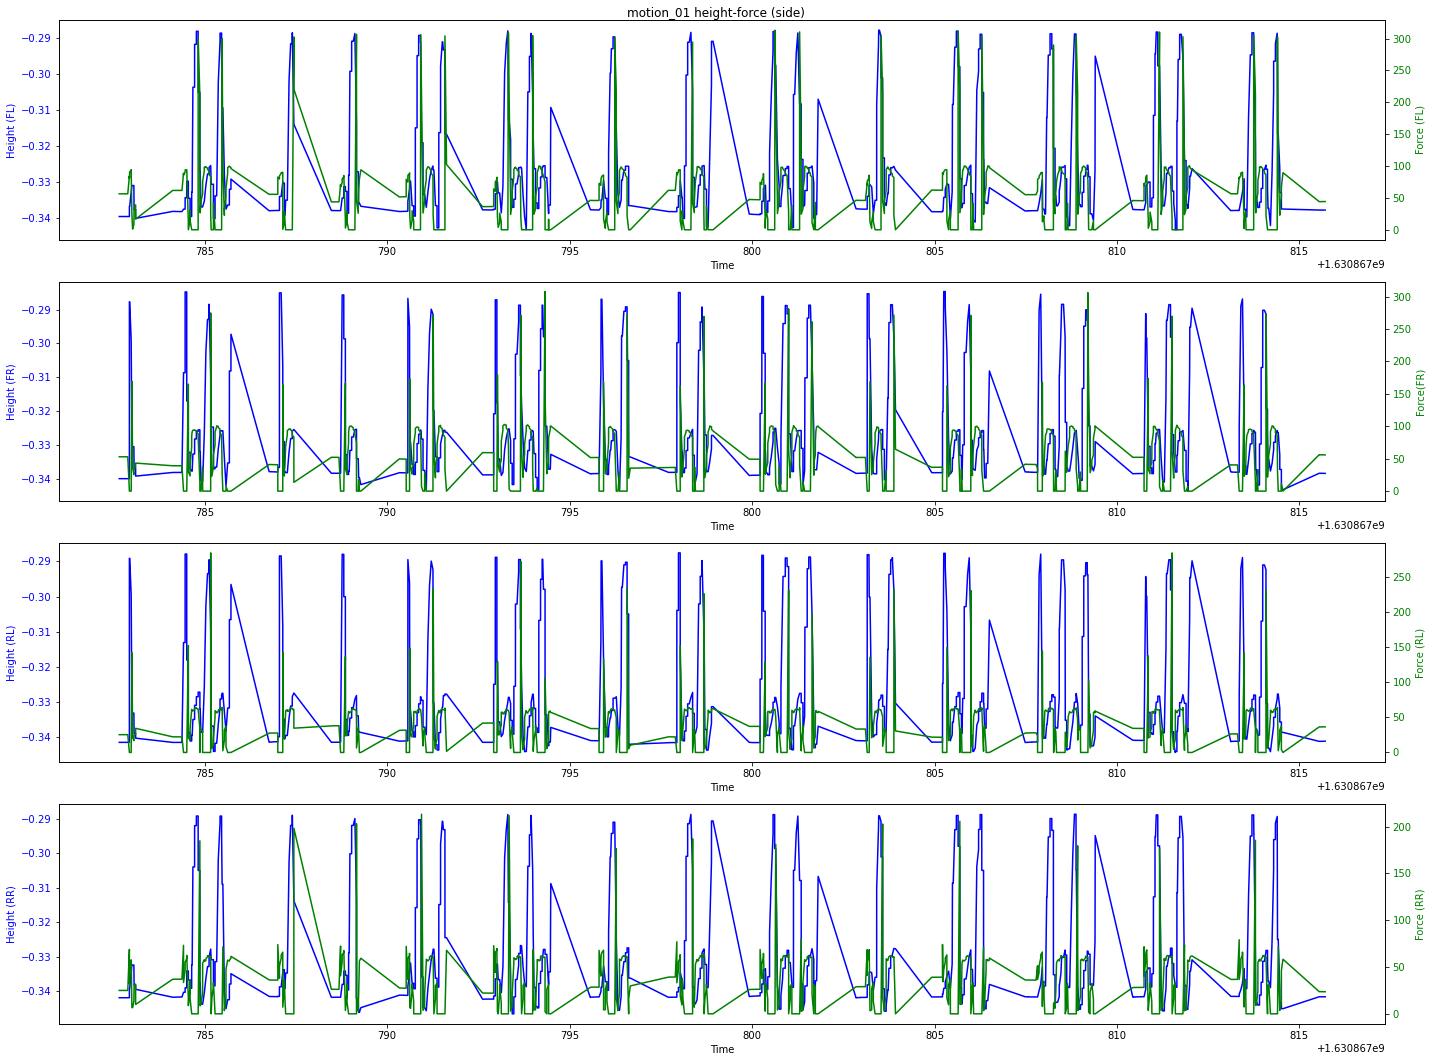

In [16]:
# Side (right)
side_cmds = get_specific_cmd(motion_01, 0, -velocity, 0)
motion_01_side = motion_01[side_cmds]
fr_min_height,fl_min_height,rr_min_height,rl_min_height = get_swinging_motions(motion_01_side)

sample_walking_fr_height = fr_min_height
sample_walking_fl_height = fl_min_height
sample_walking_rr_height = rr_min_height
sample_walking_rl_height = rl_min_height

plot_overlapping_data("motion_01 height-force (side)",
                      motion_01,
                      [sample_walking_fr_height, 
                       sample_walking_fl_height, 
                       sample_walking_rr_height,
                       sample_walking_rl_height],
                       [9, 21, 12, 24, 15, 27, 18, 30])

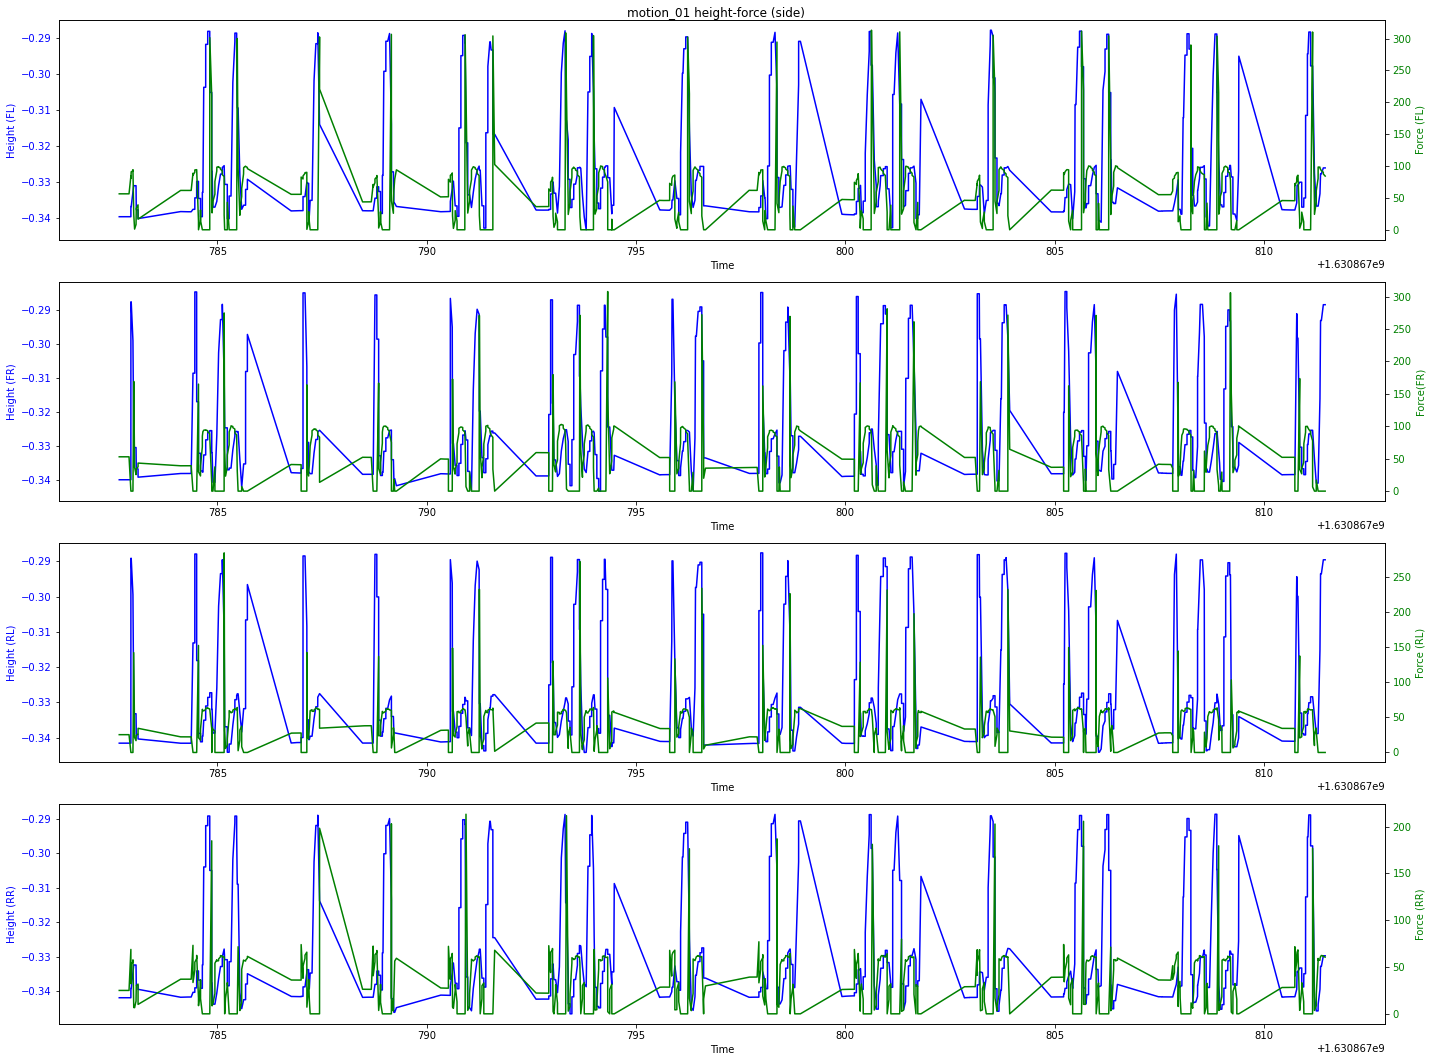

In [17]:
# Side (left)
side_cmds = get_specific_cmd(motion_01, 0, velocity, 0)
motion_01_side = motion_01[side_cmds]
fr_min_height,fl_min_height,rr_min_height,rl_min_height = get_swinging_motions(motion_01_side)

sample_walking_fr_height = fr_min_height
sample_walking_fl_height = fl_min_height
sample_walking_rr_height = rr_min_height
sample_walking_rl_height = rl_min_height

plot_overlapping_data("motion_01 height-force (side)",
                      motion_01,
                      [sample_walking_fr_height, 
                       sample_walking_fl_height, 
                       sample_walking_rr_height,
                       sample_walking_rl_height],
                       [9, 21, 12, 24, 15, 27, 18, 30])

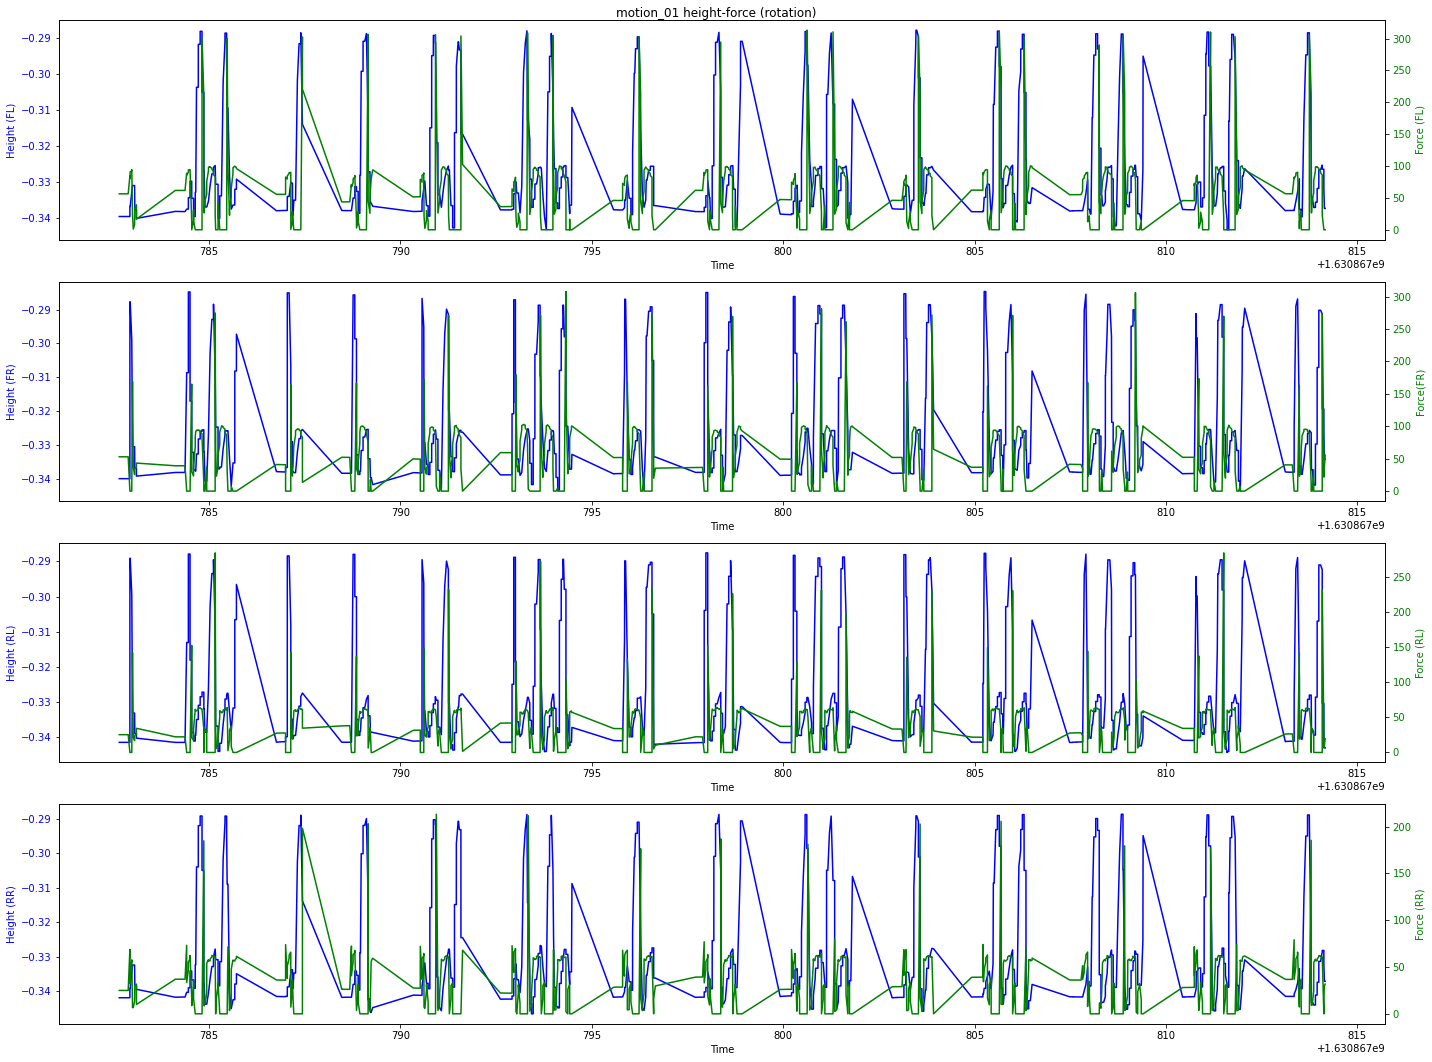

In [18]:
# Rotation (clockwise)
rot_cmds = get_specific_cmd(motion_01, 0, 0, -velocity)
motion_01_rot = motion_01[rot_cmds]
fr_min_height,fl_min_height,rr_min_height,rl_min_height = get_swinging_motions(motion_01_rot)

sample_walking_fr_height = fr_min_height
sample_walking_fl_height = fl_min_height
sample_walking_rr_height = rr_min_height
sample_walking_rl_height = rl_min_height

plot_overlapping_data("motion_01 height-force (rotation)",
                      motion_01,
                      [sample_walking_fr_height, 
                       sample_walking_fl_height, 
                       sample_walking_rr_height,
                       sample_walking_rl_height],
                       [9, 21, 12, 24, 15, 27, 18, 30])

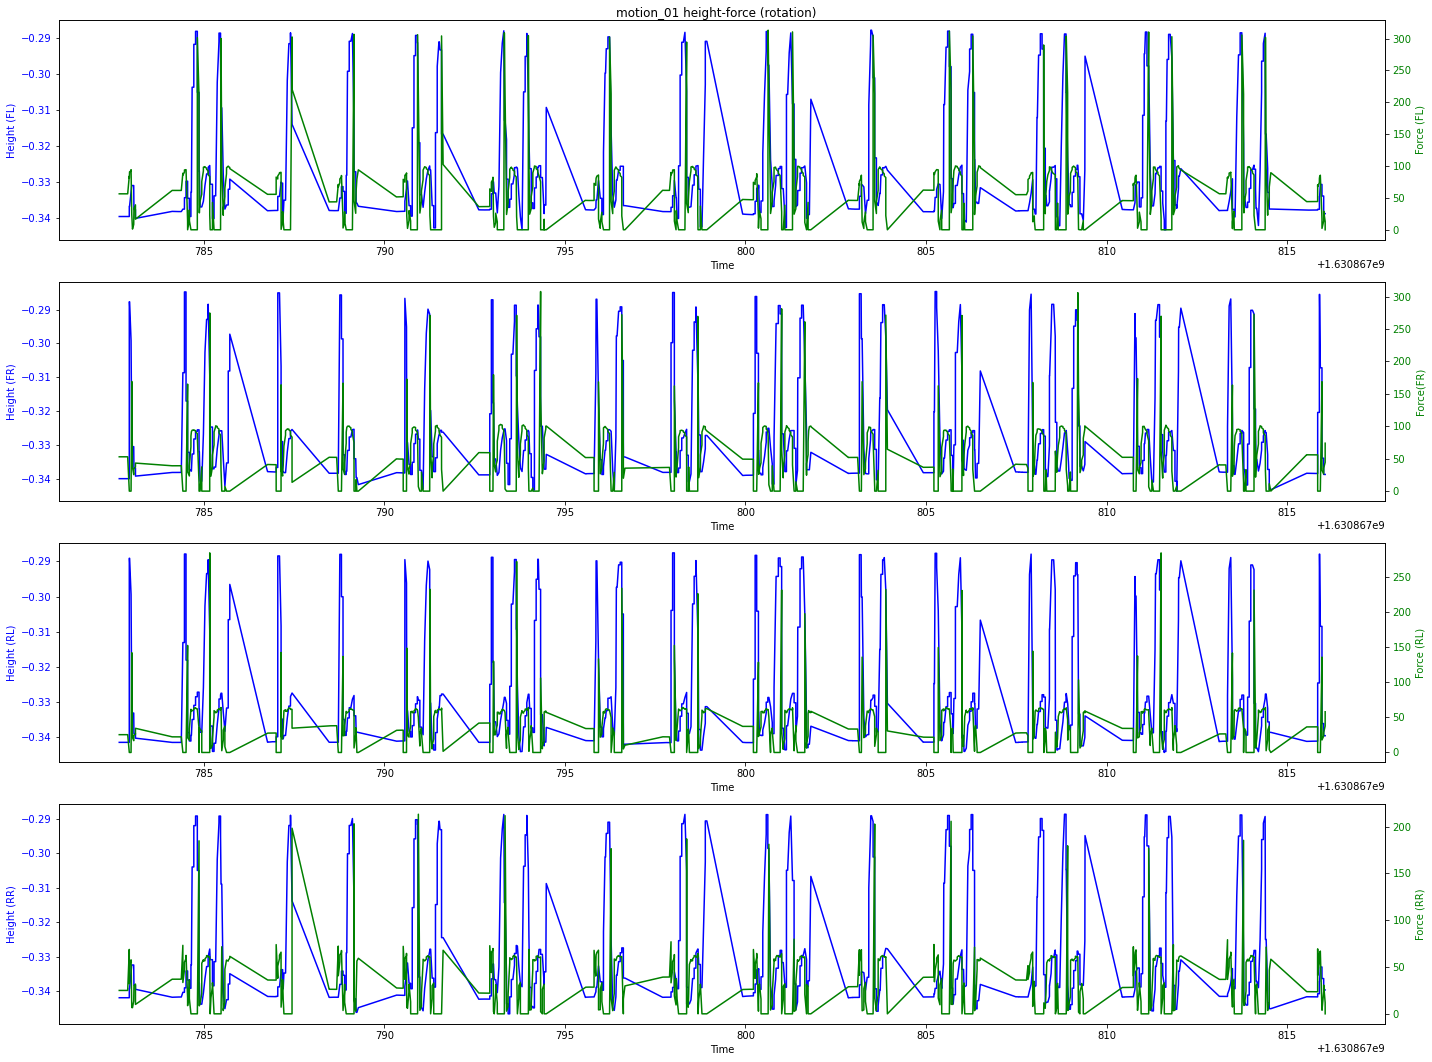

In [19]:
# Rotation (counter clockwise)
rot_cmds = get_specific_cmd(motion_01, 0, 0, velocity)
motion_01_rot = motion_01[rot_cmds]
fr_min_height,fl_min_height,rr_min_height,rl_min_height = get_swinging_motions(motion_01_rot)

sample_walking_fr_height = fr_min_height
sample_walking_fl_height = fl_min_height
sample_walking_rr_height = rr_min_height
sample_walking_rl_height = rl_min_height

plot_overlapping_data("motion_01 height-force (rotation)",
                      motion_01,
                      [sample_walking_fr_height, 
                       sample_walking_fl_height, 
                       sample_walking_rr_height,
                       sample_walking_rl_height],
                       [9, 21, 12, 24, 15, 27, 18, 30])

## Footsteps Extraction (Height + Force)

In [13]:
"""
    Extract footsteps from raw data using
    force and height measurements together.
"""
def extract_footsteps(dataset, height_threshold=0.1, force_thresholds=[100,100,100,100]):
    # Compute height difference for FR and FL
    fr_fl_diff = np.round(abs(dataset[:, 9] - dataset[:, 12]), 9)
    print("Max diff between fr and fl: ", max(fr_fl_diff))

    # Compute height difference for RR and RL
    rr_rl_diff = np.round(abs(dataset[:, 15] - dataset[:, 18]), 9)
    print("Max diff between rr and rl: ", max(rr_rl_diff))

    # Compute compound difference for all foots
    height_diff = np.round(fr_fl_diff + rr_rl_diff, 9)
    print("Min and max diff between front and rear feet", min(height_diff), max(height_diff), "\n")
    
    # Find footsteps (based on height difference)
    footsteps_height = np.where(height_diff < height_threshold)[0]
    print("Amount of footsteps found with height criteria: ", len(footsteps_height), "\n")
    
    # Find footsteps based on force perceived
    rear_force_footsteps = np.where(np.logical_or(dataset[:, 21] <= force_thresholds[0], dataset[:, 24] <= force_thresholds[1]))[0]
    front_force_footsteps = np.where(np.logical_or(dataset[:, 27] <= force_thresholds[2], dataset[:, 30] <= force_thresholds[3]))[0]
    
    # Find footsteps that match force constraints on all foot
    footsteps_force = np.intersect1d(rear_force_footsteps, front_force_footsteps)
    print("Number of force footsteps: ", len(footsteps_force), "\n")
    
    # Find force and height footsteps intersection
    force_height_footsteps = np.intersect1d(footsteps_force, footsteps_height)
    print("Number of height-force footsteps: ", len(force_height_footsteps), "\n")
    
    return force_height_footsteps


"""
    Perform non-maximum-suppresion on the 
    footsteps found as multiple instances
    are found within a small time window.
"""
def footsteps_nms(dataset, footsteps):
    footsteps_nms = []

    idx = 0
    footstep_to_add = footsteps[0]
    
    # Iterate over the footsteps
    while idx < (len(footsteps) - 1):
        # Compute time difference between
        # current and next footsteps
        time_difference = abs(dataset[footsteps[idx], 0] - dataset[footsteps[idx+1], 0])
        
        # Find corresponding index in between
        # the current and next footsteps
        time_differences = np.abs(dataset[:, 0] - (dataset[footsteps[idx], 0] + time_difference/2))
        matching_index = time_differences.argmin()
        
        # Retrieve what is the maximum height
        # reached in between the current and
        # next footstep
        height_peek_in_between = max([dataset[matching_index, x] for x in [9, 12, 15, 18]])
        
        # Within same time window but not consecute footsteps
        if time_difference < 0.1 and not height_peek_in_between > -0.31:
            # Compute height difference between feet
            #height_diff_idx = abs(dataset[footsteps[idx], 9] - dataset[footsteps[idx], 12]) + abs(dataset[footsteps[idx], 15] - dataset[footsteps[idx], 18])
            #height_diff_idx_next = abs(dataset[footsteps[idx+1], 9] - dataset[footsteps[idx+1], 12]) + abs(dataset[footsteps[idx+1], 15] - dataset[footsteps[idx+1], 18])
                
            # Choose foot with lowest height difference
            #footstep_to_add = footsteps[idx] if height_diff_idx < height_diff_idx_next else footsteps[idx+1]
            #timestamp_of_footstep_to_add = dataset[footsteps[idx], 0] if height_diff_idx < height_diff_idx_next else dataset[footsteps[idx+1], 0] 
            
            footstep_to_add = footsteps[idx] if dataset[footsteps[idx], 0] < dataset[footsteps[idx+1], 0] else footsteps[idx+1]
        elif time_difference < 0.1 and height_peek_in_between > -0.31:
            footsteps_nms.append(footstep_to_add)
        elif time_difference > 0.1:
            footsteps_nms.append(footstep_to_add)
        
        idx += 1
        
    return np.asarray(footsteps_nms)

## Footsteps

In [14]:
def footstep_extraction_and_plotting(dataset, velocities, height_threshold, force_thresholds, indexes):
    # Extract backward motion entries
    cmds = get_specific_cmd(dataset, velocities[0], velocities[1], velocities[2])
    motion_01_cmds = motion_01[cmds]
    fr_min_height, fl_min_height, rr_min_height, rl_min_height = get_swinging_motions(motion_01_cmds)
    print("Foot swinging motions lenghts: ", len(fr_min_height), len(fl_min_height), len(rr_min_height), len(rl_min_height))
    
    # Extract footsteps
    footsteps = extract_footsteps(motion_01_cmds, height_threshold, force_thresholds)
    print("Footsteps extracted: ", len(footsteps))
    
    # Footsteps NMS
    footsteps_after_nms = footsteps_nms(motion_01_cmds, footsteps)
    print("Footsteps after non-maximum-suppression: ", len(footsteps_after_nms))
    
    # Plot footsteps
    sample_walking_fr_height = fr_min_height[indexes]
    sample_walking_fl_height = fl_min_height[indexes]
    sample_walking_rr_height = rr_min_height[indexes]
    sample_walking_rl_height = rl_min_height[indexes]

    plot_overlapping_data("Footsteps",
                          motion_01_cmds,
                          [sample_walking_fr_height, 
                           sample_walking_fl_height, 
                           sample_walking_rr_height,
                           sample_walking_rl_height],
                           [9, 21, 12, 24, 15, 27, 18, 30],
                           True,
                           motion_01_cmds[footsteps_nms(motion_01_cmds, footsteps), 0])
                           #motion_01_cmds[footsteps, 0])
    
    return motion_01_cmds, footsteps_after_nms

### Forward motion

Foot swinging motions lenghts:  1008 1008 1008 1008
Max diff between fr and fl:  0.049593866
Max diff between rr and rl:  0.05142045
Min and max diff between front and rear feet 2.0176e-05 0.101014316 

Amount of footsteps found with height criteria:  560 

Number of force footsteps:  959 

Number of height-force footsteps:  541 

Footsteps extracted:  541
Footsteps after non-maximum-suppression:  64


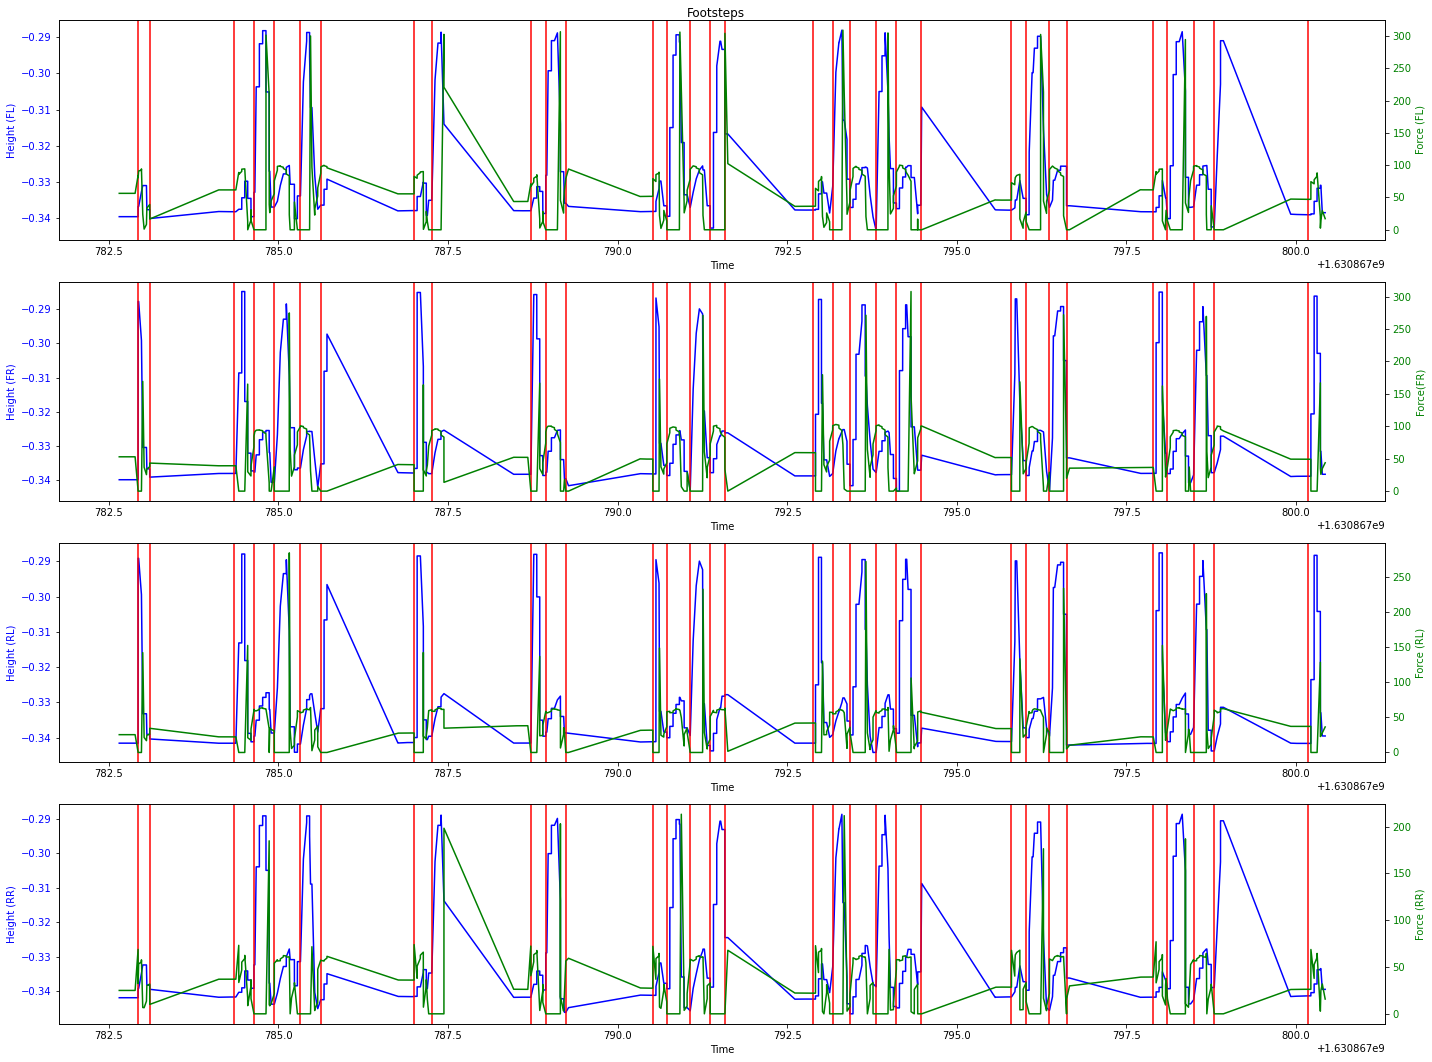

In [15]:
motion_01_fwd, footsteps_01_fwd = footstep_extraction_and_plotting(dataset=motion_01, velocities=[velocity, 0, 0], height_threshold=0.02, force_thresholds=[50,50,50,50], indexes=range(0, 500))

### Backward motion

In [16]:
#motion_01_bwd, footsteps_01_bwd = footstep_extraction_and_plotting(dataset=motion_01, velocities=[-velocity, 0, 0], height_threshold=0.02, force_thresholds=[50,50,50,50], indexes=range(0, 500))

### Side motion (right)

Foot swinging motions lenghts:  971 971 971 971
Max diff between fr and fl:  0.048698694
Max diff between rr and rl:  0.051363468
Min and max diff between front and rear feet 2.5034e-05 0.098949849 

Amount of footsteps found with height criteria:  503 

Number of force footsteps:  910 

Number of height-force footsteps:  465 

Footsteps extracted:  465
Footsteps after non-maximum-suppression:  58


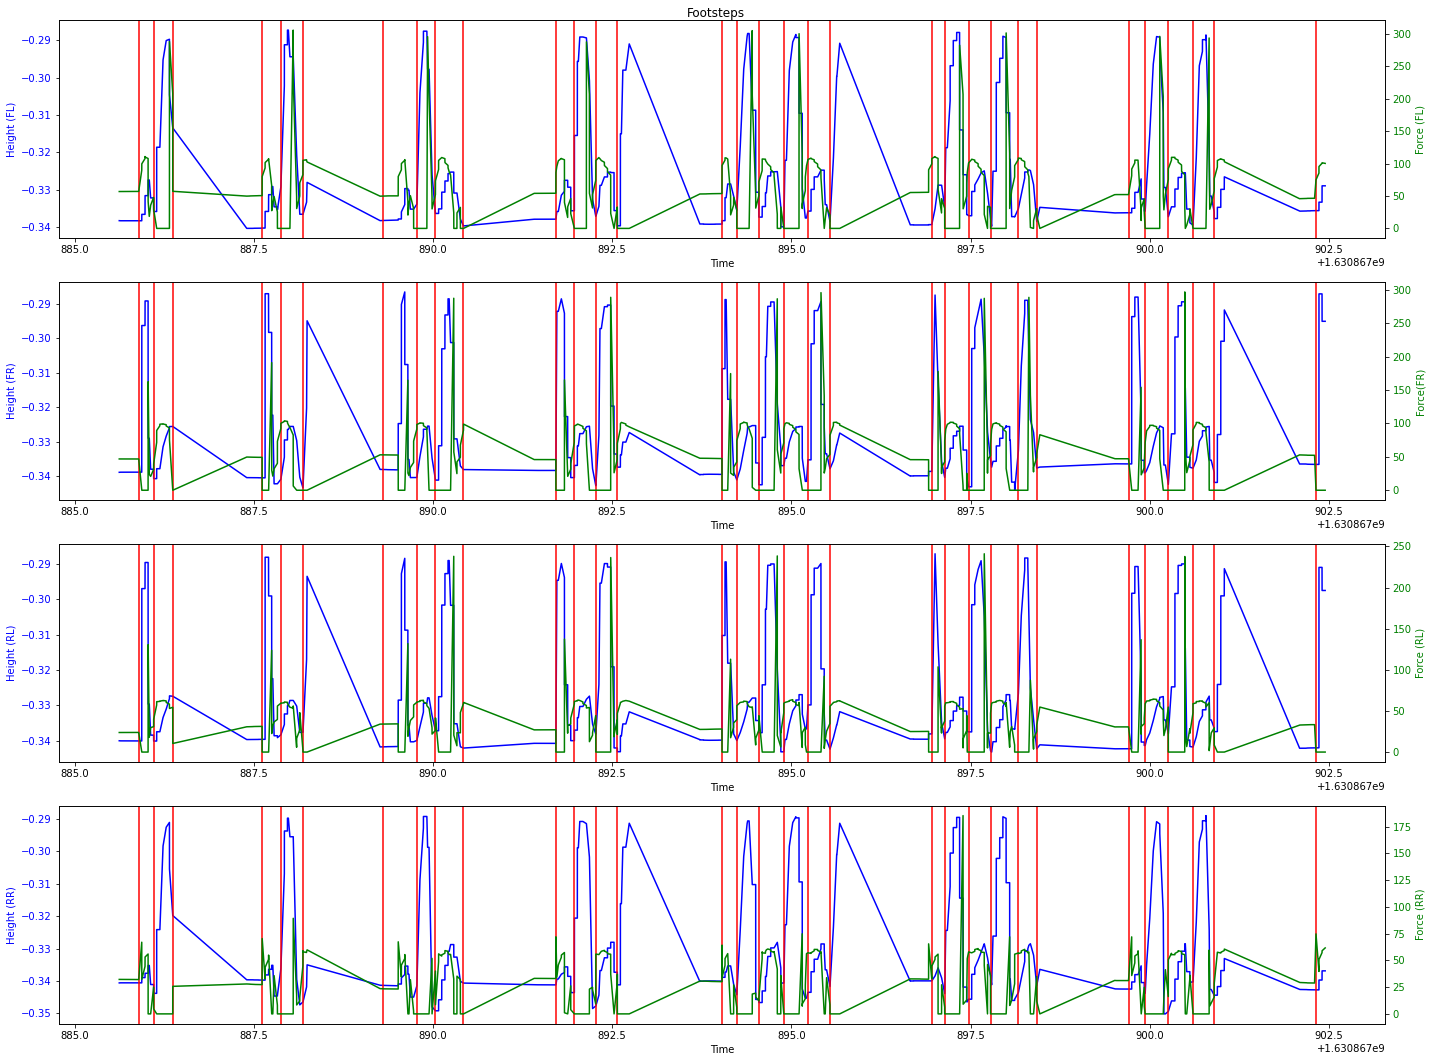

In [17]:
motion_01_side_right, footsteps_01_side_right = footstep_extraction_and_plotting(dataset=motion_01, velocities=[0, -velocity, 0],  height_threshold=0.02, force_thresholds=[50,50,50,50], indexes=range(0, 500))

### Side (left)

Foot swinging motions lenghts:  856 856 856 856
Max diff between fr and fl:  0.049870431
Max diff between rr and rl:  0.050071985
Min and max diff between front and rear feet 0.000213176 0.099818289 

Amount of footsteps found with height criteria:  467 

Number of force footsteps:  807 

Number of height-force footsteps:  451 

Footsteps extracted:  451
Footsteps after non-maximum-suppression:  56


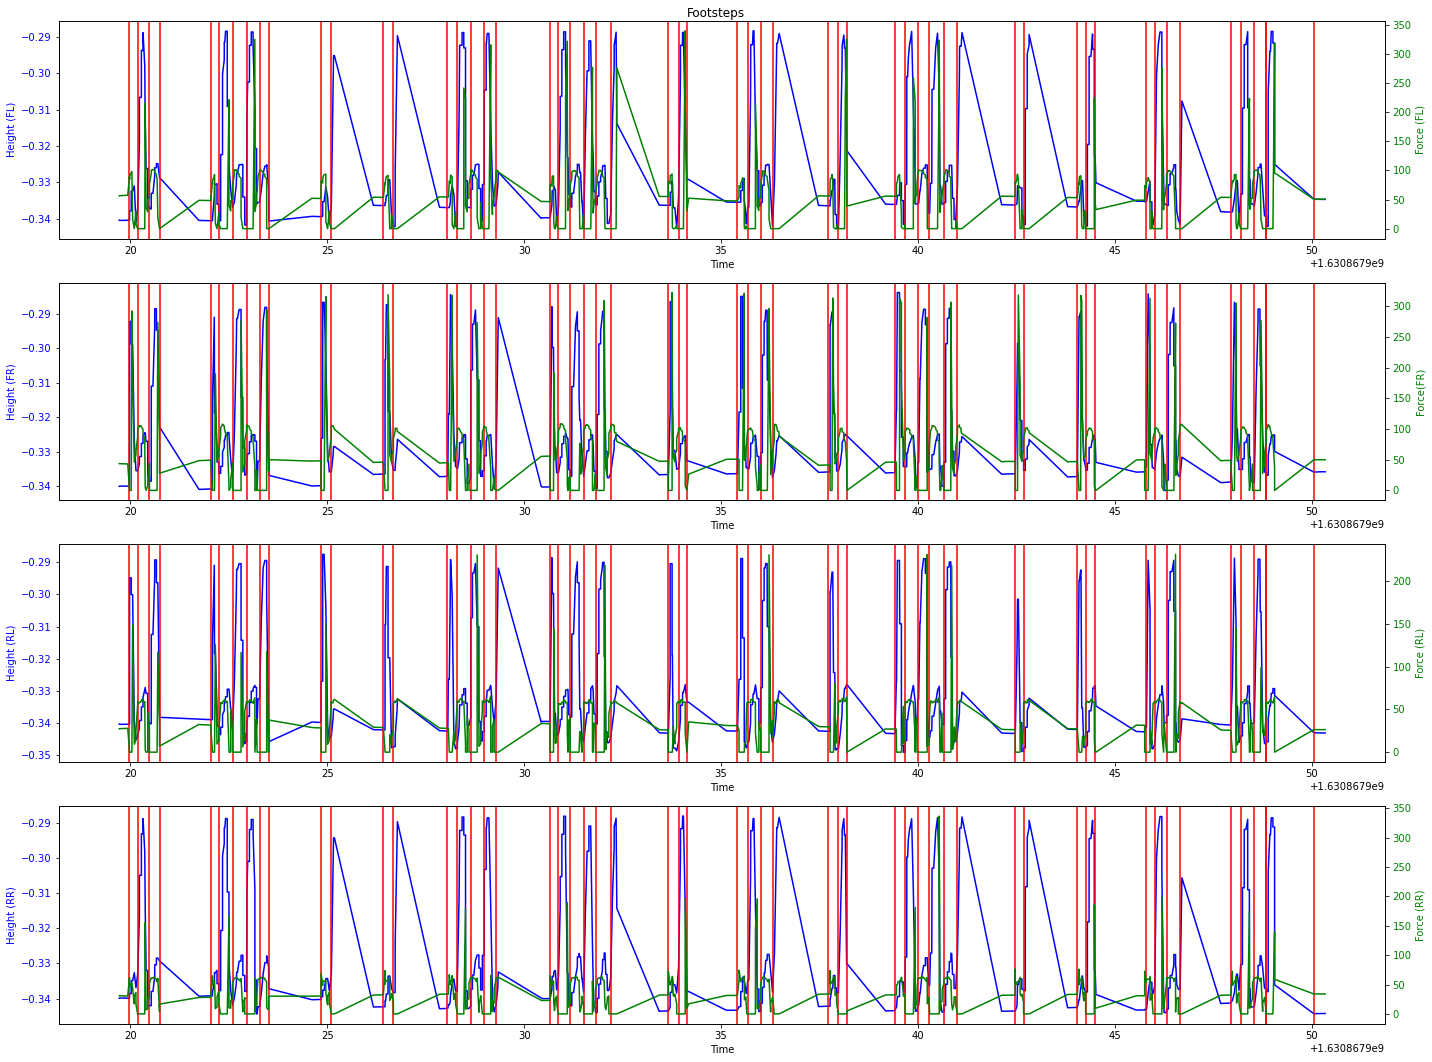

In [18]:
motion_01_side_left, footsteps_01_side_left = footstep_extraction_and_plotting(dataset=motion_01, velocities=[0, velocity, 0],  height_threshold=0.02, force_thresholds=[50,50,50,50], indexes=range(0, 850))

### Rotation (clockwise)

Foot swinging motions lenghts:  943 943 943 943
Max diff between fr and fl:  0.049715221
Max diff between rr and rl:  0.051339895
Min and max diff between front and rear feet 3.3617e-05 0.100894332 

Amount of footsteps found with height criteria:  528 

Number of force footsteps:  878 

Number of height-force footsteps:  491 

Footsteps extracted:  491
Footsteps after non-maximum-suppression:  62


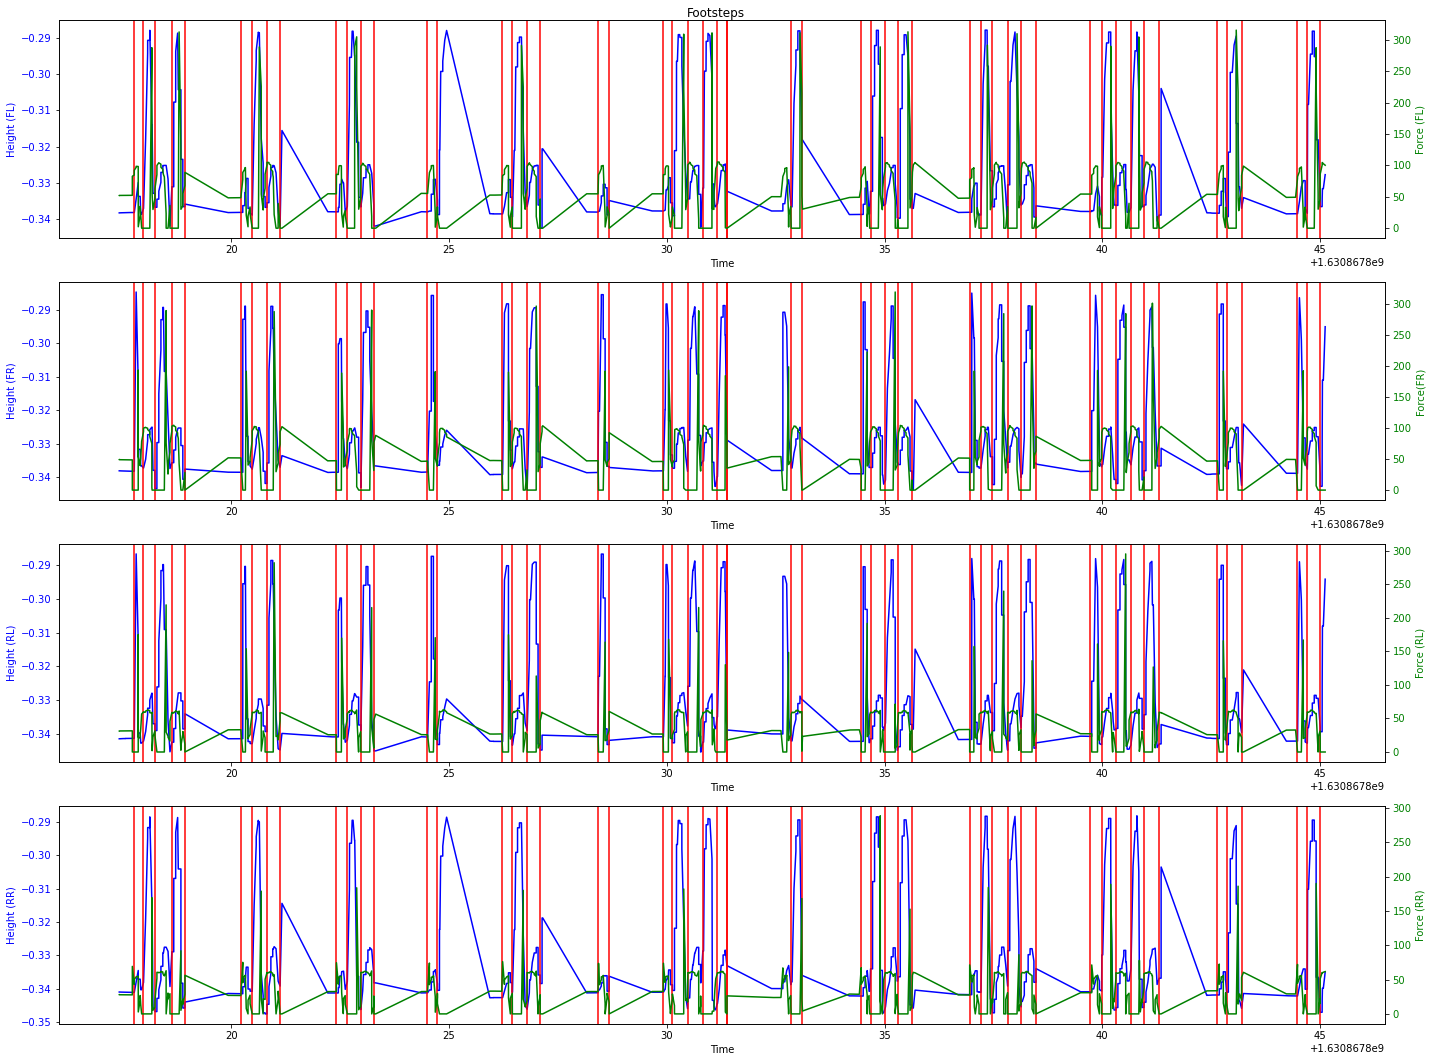

In [19]:
motion_01_clock, footsteps_01_clock = footstep_extraction_and_plotting(dataset=motion_01, velocities=[0, 0, -velocity],  height_threshold=0.02, force_thresholds=[50,50,50,50], indexes=range(0, 800))

### Rotation (counter clockwise)

Foot swinging motions lenghts:  989 989 989 989
Max diff between fr and fl:  0.049989402
Max diff between rr and rl:  0.050211966
Min and max diff between front and rear feet 6.6578e-05 0.100201368 

Amount of footsteps found with height criteria:  540 

Number of force footsteps:  946 

Number of height-force footsteps:  530 

Footsteps extracted:  530
Footsteps after non-maximum-suppression:  64


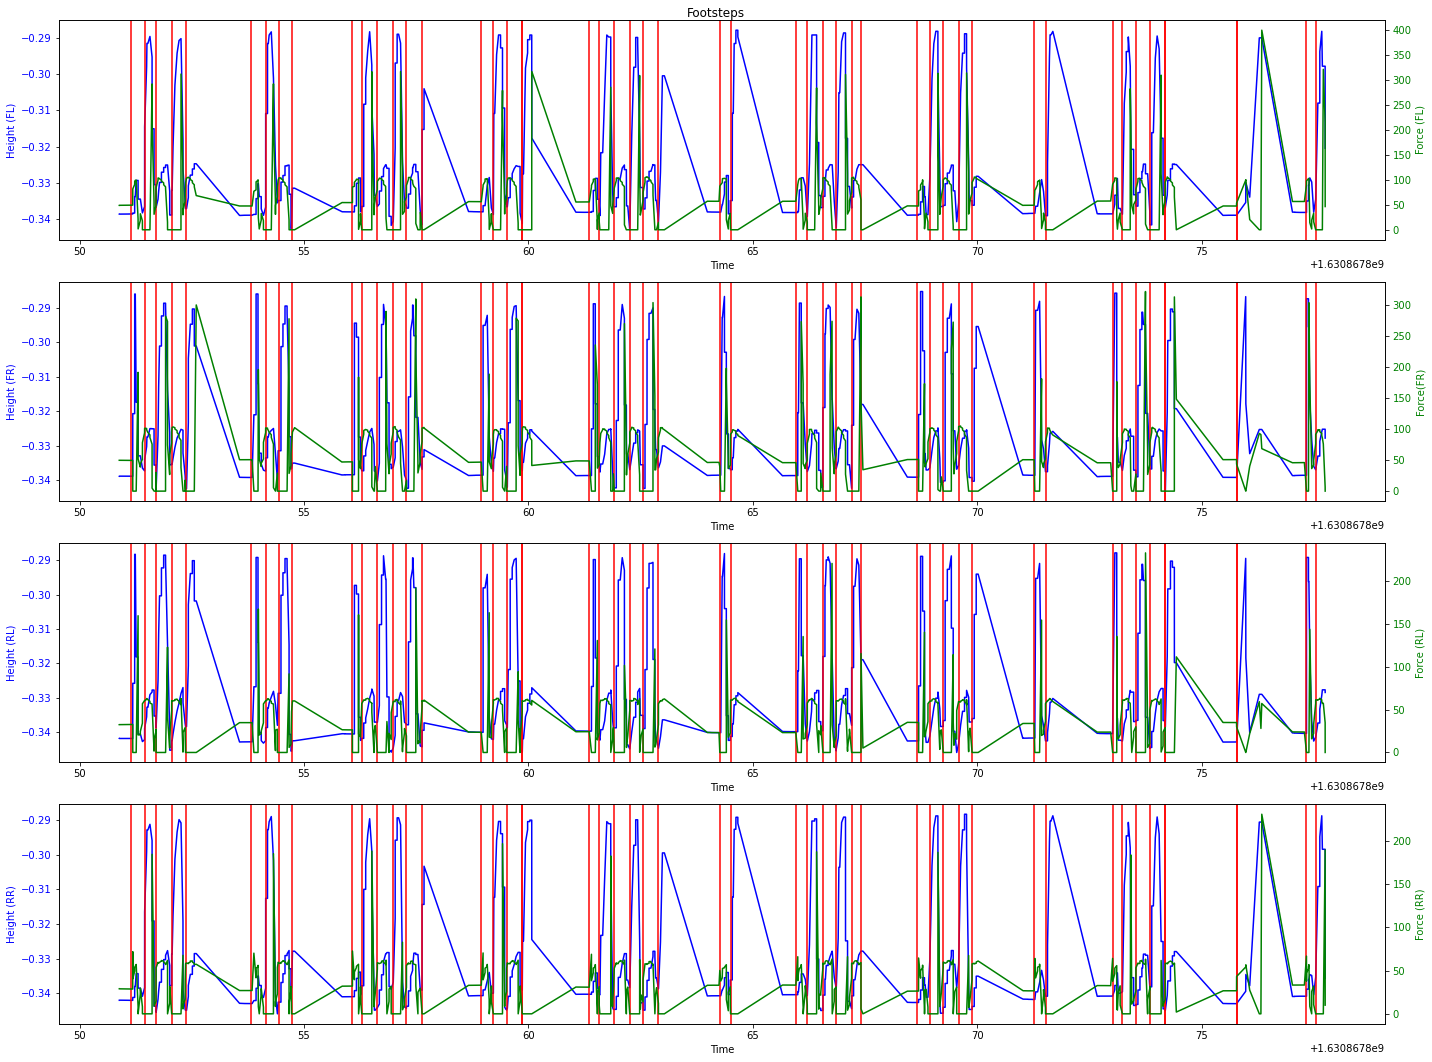

In [20]:
motion_01_count, footsteps_01_count = footstep_extraction_and_plotting(dataset=motion_01, velocities=[0, 0, velocity],  height_threshold=0.02, force_thresholds=[50,50,50,50], indexes=range(0, 800))

### Step size

In [28]:
def get_step_size(dataset, footsteps, idx_coord=[7,10,13,16]):
    # Footsteps sizes
    step_size_fr = []
    step_size_fl = []
    step_size_rr = []
    step_size_rl = []
    footstep_period = []
    
    # Compute step sizes
    for idx, footstep in enumerate(footsteps):
        if idx > 0:
            time_diff = dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0]
            #print("Time diff: ", time_diff)

            if time_diff < 1.0:
                footstep_period.append(time_diff)
                step_size_fl.append(dataset[footsteps[idx], idx_coord[0]] - dataset[footsteps[idx-1], idx_coord[0]])
                step_size_fr.append(dataset[footsteps[idx], idx_coord[1]] - dataset[footsteps[idx-1], idx_coord[1]])
                step_size_rl.append(dataset[footsteps[idx], idx_coord[2]] - dataset[footsteps[idx-1], idx_coord[2]])
                step_size_rr.append(dataset[footsteps[idx], idx_coord[3]] - dataset[footsteps[idx-1], idx_coord[3]])
    
    # Convert to numpy array
    step_size_fl_numpy = np.array(step_size_fl)
    step_size_fr_numpy = np.array(step_size_fr)
    step_size_rl_numpy = np.array(step_size_rl)
    step_size_rr_numpy = np.array(step_size_rr)
    footstep_period_numpy = np.array(footstep_period)
    
    # Only keep positive footsteps
    step_size_fl_numpy = step_size_fl_numpy[np.where(step_size_fl_numpy > 0)[0]]
    step_size_fr_numpy = step_size_fr_numpy[np.where(step_size_fr_numpy > 0)[0]]
    step_size_rl_numpy = step_size_rl_numpy[np.where(step_size_rl_numpy > 0)[0]]
    step_size_rr_numpy = step_size_rr_numpy[np.where(step_size_rr_numpy > 0)[0]]
                
    # Print average step-size
    print("Avg. step size time: ", np.mean(footstep_period_numpy))
    print("Min. step size time: ", np.min(footstep_period_numpy))
    print("Max. step size time: ", np.max(footstep_period_numpy))
    print("Std. step size time: ", np.std(footstep_period_numpy), "\n")
    #print(footstep_period_numpy)
    print("Avg. step size for FL foot: ", np.mean(step_size_fl_numpy))
    print("Avg. step size for FR foot: ", np.mean(step_size_fr_numpy))
    print("Avg. step size for RL foot: ", np.mean(step_size_rl_numpy))
    print("Avg. step size for RR foot: ", np.mean(step_size_rr_numpy), '\n')

    # Print std. dev. step-size
    print("Std. dev. step size for FL foot: ", np.std(step_size_fl_numpy))
    print("Std. dev. step size for FR foot: ", np.std(step_size_fr_numpy))
    print("Std. dev. step size for RL foot: ", np.std(step_size_rl_numpy))
    print("Std. dev. step size for RR foot: ", np.std(step_size_rr_numpy), '\n')
    
    return step_size_fr_numpy, step_size_fl_numpy, step_size_rr_numpy, step_size_rl_numpy

#### Forward motion

In [29]:
# Step size and velocity along x axis 
step_size_fr_x_fwd,_,_,_ = get_step_size(motion_01_fwd, footsteps_01_fwd)

Avg. step size time:  0.2888577179032929
Min. step size time:  0.0
Max. step size time:  0.38472485542297363
Std. step size time:  0.06821050827092727 

Avg. step size for FL foot:  0.028524398058652877
Avg. step size for FR foot:  0.01951430578316961
Avg. step size for RL foot:  0.019991543676171983
Avg. step size for RR foot:  0.027186854183673857 

Std. dev. step size for FL foot:  0.004472946474832868
Std. dev. step size for FR foot:  0.008935549957705756
Std. dev. step size for RL foot:  0.00819804576269344
Std. dev. step size for RR foot:  0.004416313613565325 



In [82]:
# Step size along y axis 
_,_,_,_ = get_step_size(motion_01_fwd, footsteps_01_fwd, idx_coord=[8, 11, 14, 17])

Avg. step size time:  0.314894873426255
Min. step size time:  0.0
Max. step size time:  0.6509053707122803
Std. step size time:  0.0487314549989742 

Avg. step size for FL foot:  0.0046535845444326505
Avg. step size for FR foot:  0.0022517982656243204
Avg. step size for RL foot:  0.0017600476497979663
Avg. step size for RR foot:  0.000974191511087572 

Std. dev. step size for FL foot:  0.0017872686320903627
Std. dev. step size for FR foot:  0.002154550425201401
Std. dev. step size for RL foot:  0.002191938172036802
Std. dev. step size for RR foot:  0.0009662084312975361 



### Backward motion

In [83]:
# Step size and velocity along x axis 
#step_size_fr_x,_,_,_ = get_step_size(motion_01_bwd, footsteps_01_bwd)

In [84]:
# Step size along y axis 
#_,_,_,_ = get_step_size(motion_01_bwd, footsteps_01_bwd, idx_coord=[8, 11, 14, 17])

### Side motion (right)

In [85]:
# Step size and velocity along x axis 
step_size_fr_x,_,_,_ = get_step_size(motion_01_side_right, footsteps_01_side_right)

Avg. step size time:  0.31378618340571224
Min. step size time:  0.0
Max. step size time:  0.5971825122833252
Std. step size time:  0.05021604872783718 

Avg. step size for FL foot:  0.007237652157489051
Avg. step size for FR foot:  0.0025973254094710067
Avg. step size for RL foot:  0.0057664186079451375
Avg. step size for RR foot:  0.00627937315381723 

Std. dev. step size for FL foot:  0.0017114666408376633
Std. dev. step size for FR foot:  0.0007354833104055937
Std. dev. step size for RL foot:  0.0031082448081720853
Std. dev. step size for RR foot:  0.0016868286724436375 



In [86]:
# Step size along y axis 
_,_,_,_ = get_step_size(motion_01_side_right, footsteps_01_side_right, idx_coord=[8, 11, 14, 17])

Avg. step size time:  0.31378618340571224
Min. step size time:  0.0
Max. step size time:  0.5971825122833252
Std. step size time:  0.05021604872783718 

Avg. step size for FL foot:  0.0382990329153637
Avg. step size for FR foot:  0.028970435569833097
Avg. step size for RL foot:  0.03081074715556955
Avg. step size for RR foot:  0.03341314074928249 

Std. dev. step size for FL foot:  0.0059984150655464
Std. dev. step size for FR foot:  0.005539064854658783
Std. dev. step size for RL foot:  0.0037979990084912618
Std. dev. step size for RR foot:  0.004025933235378328 



### Side motions (left)

In [87]:
# Step size and velocity along x axis 
step_size_fr_x,_,_,_ = get_step_size(motion_01_side_left, footsteps_01_side_left)

Avg. step size time:  0.31299370019010797
Min. step size time:  0.0
Max. step size time:  0.43512988090515137
Std. step size time:  0.05280922497868728 

Avg. step size for FL foot:  0.003327224047455061
Avg. step size for FR foot:  0.0056225996019022536
Avg. step size for RL foot:  0.007378743118361423
Avg. step size for RR foot:  0.00837216577940606 

Std. dev. step size for FL foot:  0.000620654853639091
Std. dev. step size for FR foot:  0.0006387823934466277
Std. dev. step size for RL foot:  0.0016958674388663818
Std. dev. step size for RR foot:  0.0027451212174207057 



In [88]:
# Step size along y axis 
_,_,_,_ = get_step_size(motion_01_side_left, footsteps_01_side_left, idx_coord=[8, 11, 14, 17])

Avg. step size time:  0.31299370019010797
Min. step size time:  0.0
Max. step size time:  0.43512988090515137
Std. step size time:  0.05280922497868728 

Avg. step size for FL foot:  0.03165059576836585
Avg. step size for FR foot:  0.033961735632462256
Avg. step size for RL foot:  0.028954378235460126
Avg. step size for RR foot:  0.03208288182253593 

Std. dev. step size for FL foot:  0.003653144914304101
Std. dev. step size for FR foot:  0.004889472190770086
Std. dev. step size for RL foot:  0.007425401532964828
Std. dev. step size for RR foot:  0.0028804815541663233 



### Rotation (clockwise)

In [89]:
# Step size and velocity along x axis 
step_size_fr_x,_,_,_ = get_step_size(motion_01_clock, footsteps_01_clock)

Avg. step size time:  0.3142764916713859
Min. step size time:  0.0
Max. step size time:  0.4230175018310547
Std. step size time:  0.05050212296640196 

Avg. step size for FL foot:  0.0004180615439134486
Avg. step size for FR foot:  0.007386491557349374
Avg. step size for RL foot:  0.003814346023968288
Avg. step size for RR foot:  0.012151389977985755 

Std. dev. step size for FL foot:  0.0003751536071556112
Std. dev. step size for FR foot:  0.001220640563927828
Std. dev. step size for RL foot:  0.0019260736123392593
Std. dev. step size for RR foot:  0.004029060355226337 



In [90]:
# Step size along y axis 
_,_,_,_ = get_step_size(motion_01_clock, footsteps_01_clock, idx_coord=[8, 11, 14, 17])

Avg. step size time:  0.3142764916713859
Min. step size time:  0.0
Max. step size time:  0.4230175018310547
Std. step size time:  0.05050212296640196 

Avg. step size for FL foot:  0.010361382607318441
Avg. step size for FR foot:  0.0031490277066163466
Avg. step size for RL foot:  0.010812390425554081
Avg. step size for RR foot:  0.010066824765537457 

Std. dev. step size for FL foot:  0.0022144670136392784
Std. dev. step size for FR foot:  0.0018780362616845488
Std. dev. step size for RL foot:  0.003149540485314136
Std. dev. step size for RR foot:  0.0014273583387382307 



### Rotation (counter clockwise)

In [91]:
# Step size and velocity along x axis 
step_size_fr_x,_,_,_ = get_step_size(motion_01_count, footsteps_01_count)

Avg. step size time:  0.30748880200565526
Min. step size time:  0.0
Max. step size time:  0.4314441680908203
Std. step size time:  0.074954741726417 

Avg. step size for FL foot:  0.009580454856250727
Avg. step size for FR foot:  0.0006503300760921679
Avg. step size for RL foot:  0.012583683637073172
Avg. step size for RR foot:  0.003857867963730343 

Std. dev. step size for FL foot:  0.001370757159350007
Std. dev. step size for FR foot:  0.0005439244726019268
Std. dev. step size for RL foot:  0.001722359367673291
Std. dev. step size for RR foot:  0.0019411842298957826 



In [92]:
# Step size along y axis 
_,_,_,_ = get_step_size(motion_01_count, footsteps_01_count, idx_coord=[8, 11, 14, 17])

Avg. step size time:  0.30748880200565526
Min. step size time:  0.0
Max. step size time:  0.4314441680908203
Std. step size time:  0.074954741726417 

Avg. step size for FL foot:  0.002539936375408612
Avg. step size for FR foot:  0.008596209725491554
Avg. step size for RL foot:  0.007870194008168968
Avg. step size for RR foot:  0.011811605690664135 

Std. dev. step size for FL foot:  0.0014425520431982422
Std. dev. step size for FR foot:  0.0016115231017850482
Std. dev. step size for RL foot:  0.0014076762540668312
Std. dev. step size for RR foot:  0.001866580920135901 



### Footstep visualization

In [60]:
def visualize_static_foosteps(dataset, footsteps):
    old_xs = None
    old_ys = None
    old_zs = None
    
    # Visualize footsteps
    for idx, footstep in enumerate(footsteps):
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

        #ax.set_xlim([-0.5, 0.5])
        #ax.set_ylim([-0.3, 0.3])
        ax.set_zlim([-0.5, 0.5])

        dataset[footstep, 7:19] = np.round(dataset[footstep, 7:19], 3)
        
        time_diff = dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0]
            
        # 3D positions        
        xs = np.array([dataset[footstep, 7], dataset[footstep, 10], dataset[footstep, 13], dataset[footstep, 16]])
        ys = np.array([dataset[footstep, 8], dataset[footstep, 11], dataset[footstep, 14], dataset[footstep, 17]])
        zz = np.array([dataset[footstep, 9], dataset[footstep, 12], dataset[footstep, 15], dataset[footstep, 18]])

        ax.scatter(xs, ys, zs, marker='o')

        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')

        plt.show()

        #print(xs, ys, zs, dataset[footstep, 2:5], dataset[footstep, 25:28])
        if idx > 0 and idx < len(footsteps):
            print(f'Diff: {time_diff}. Command: {dataset[footstep, 1:7]}. Coord: {[xs[0], ys[0], zs[0]]}. Step size: {[xs[0]-old_xs[0], ys[0]-old_ys[0], zs[0]-old_zs[0]]}.')
        else:
            print(f'Command: {dataset[footstep, 1:7]}. Coord: {[xs[0], ys[0], zs[0]]}.')
            
        old_xs = xs
        old_ys = ys
        old_zs = zs

In [61]:
def update_points(num, dataset, footsteps, x, y, z, points):    
    # Starting footstep index
    footstep = footsteps[num]
    
    # Round footsteps position
    dataset[footstep, 7:19] = np.round(dataset[footstep, 7:19], 3)

    # Initial footsteps 3D positions
    new_x = np.array([dataset[footstep, 7], dataset[footstep, 10], dataset[footstep, 13], dataset[footstep, 16]])
    new_y = np.array([dataset[footstep, 8], dataset[footstep, 11], dataset[footstep, 14], dataset[footstep, 17]])
    new_z = np.array([dataset[footstep, 9], dataset[footstep, 12], dataset[footstep, 15], dataset[footstep, 18]])

    # update properties
    points.set_data(new_x, new_y)
    points.set_3d_properties(new_z, 'z')

    # return modified artists
    return points

def visualize_animated_footsteps(dataset, footsteps, style: str):
    # Create figure
    fig = plt.figure()
    ax = p3.Axes3D(fig)

    # Setting the axes properties
    ax.set_xlim3d([-0.4, 0.4])
    ax.set_xlabel('X')

    ax.set_ylim3d([-0.2, 0.2])
    ax.set_ylabel('Y')

    ax.set_zlim3d([-0.5, 0.5])
    ax.set_zlabel('Z')

    # Starting footstep index
    footstep = footsteps[0]

    # Round footsteps position
    dataset[footstep, 7:19] = np.round(dataset[footstep, 7:19], 3)

    # Initial footsteps 3D positions
    x = np.array([dataset[footstep, 7], dataset[footstep, 10], dataset[footstep, 13], dataset[footstep, 16]])
    y = np.array([dataset[footstep, 8], dataset[footstep, 11], dataset[footstep, 14], dataset[footstep, 17]])
    z = np.array([dataset[footstep, 9], dataset[footstep, 12], dataset[footstep, 15], dataset[footstep, 18]])

    txt = fig.suptitle('')
    points, = ax.plot(x, y, z, style)
    
    # blit=True re-draws only the parts that have changed.
    anim = animation.FuncAnimation(fig, update_points, frames=len(footsteps), fargs=(dataset, footsteps, x, y, z, points))
    
    return anim   

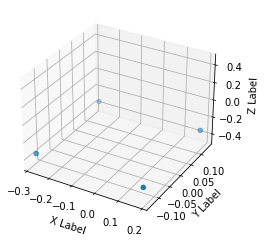

Footstep timestamp:  1630867782.9341614

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.176. FL_x (idx): 0.184. FL_y (idx+1): 0.136. FL_y (idx): 0.133
RR_x (idx+1): -0.286. RR_x (idx): -0.277. RR_y (idx+1): -0.136. RR_y (idx): -0.133
FR moving: True. Velocity: 0.1. FL_x movement: -0.008000000000000007. FL_y movement: 0.0030000000000000027. RR_x movement: -0.008999999999999952. RR_y movement: -0.0030000000000000027


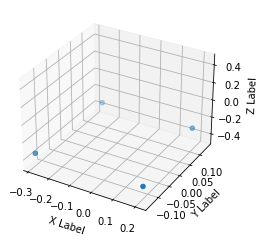

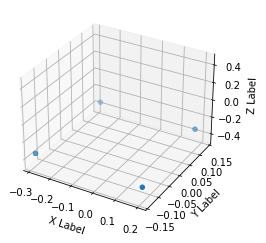

Footstep timestamp:  1630867784.3541152

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.168. FL_x (idx): 0.18. FL_y (idx+1): 0.135. FL_y (idx): 0.136
RR_x (idx+1): -0.304. RR_x (idx): -0.289. RR_y (idx+1): -0.135. RR_y (idx): -0.136
FR moving: True. Velocity: 0.1. FL_x movement: -0.011999999999999983. FL_y movement: -0.0010000000000000009. RR_x movement: -0.015000000000000013. RR_y movement: 0.0010000000000000009


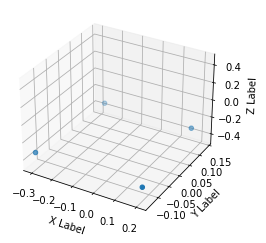

Footstep timestamp:  1630867784.6419506

FL moving: True. FR moving: False
RL moving: False. RR moving: True
FR_x (idx+1): 0.18. FR_x (idx): 0.206. FR_y (idx+1): -0.139. FR_y (idx): -0.136
RL_x (idx+1): -0.292. RL_x (idx): -0.27. RL_y (idx+1): 0.139. RL_y (idx): 0.138
FL moving: True. Velocity: 0.1. FR_x movement: -0.025999999999999995. FR_y movement: -0.0030000000000000027. RL_x movement: -0.021999999999999964. RL_y movement: 0.0010000000000000009


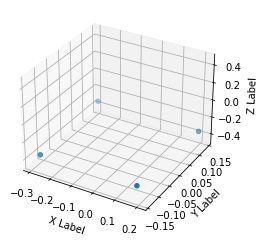

Footstep timestamp:  1630867784.9413993

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.168. FL_x (idx): 0.204. FL_y (idx+1): 0.136. FL_y (idx): 0.133
RR_x (idx+1): -0.303. RR_x (idx): -0.27. RR_y (idx+1): -0.135. RR_y (idx): -0.137
FR moving: True. Velocity: 0.1. FL_x movement: -0.035999999999999976. FL_y movement: 0.0030000000000000027. RR_x movement: -0.032999999999999974. RR_y movement: 0.0020000000000000018


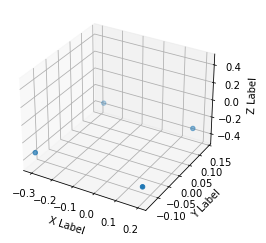

Footstep timestamp:  1630867785.326005

FL moving: True. FR moving: False
RL moving: False. RR moving: True
FR_x (idx+1): 0.169. FR_x (idx): 0.199. FR_y (idx+1): -0.136. FR_y (idx): -0.134
RL_x (idx+1): -0.304. RL_x (idx): -0.274. RL_y (idx+1): 0.136. RL_y (idx): 0.138
FL moving: True. Velocity: 0.1. FR_x movement: -0.03. FR_y movement: -0.0020000000000000018. RL_x movement: -0.02999999999999997. RL_y movement: -0.0020000000000000018


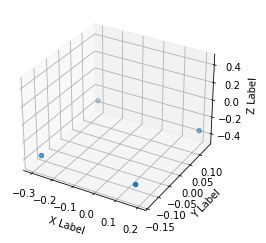

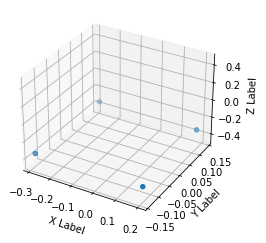

Footstep timestamp:  1630867787.002242

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.172. FL_x (idx): 0.187. FL_y (idx+1): 0.136. FL_y (idx): 0.136
RR_x (idx+1): -0.304. RR_x (idx): -0.289. RR_y (idx+1): -0.136. RR_y (idx): -0.138
FR moving: True. Velocity: 0.1. FL_x movement: -0.015000000000000013. FL_y movement: 0.0. RR_x movement: -0.015000000000000013. RR_y movement: 0.0020000000000000018


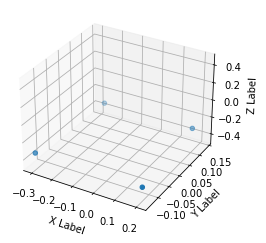

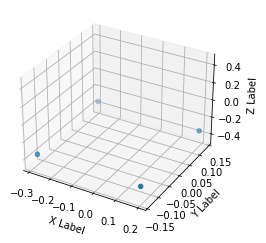

Footstep timestamp:  1630867788.7217143

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.173. FL_x (idx): 0.198. FL_y (idx+1): 0.136. FL_y (idx): 0.135
RR_x (idx+1): -0.306. RR_x (idx): -0.281. RR_y (idx+1): -0.136. RR_y (idx): -0.137
FR moving: True. Velocity: 0.1. FL_x movement: -0.025000000000000022. FL_y movement: 0.0010000000000000009. RR_x movement: -0.024999999999999967. RR_y movement: 0.0010000000000000009


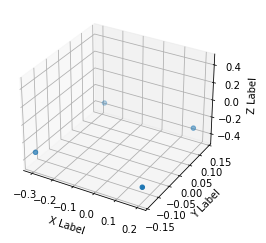

Footstep timestamp:  1630867788.9426699

FL moving: True. FR moving: False
RL moving: False. RR moving: True
FR_x (idx+1): 0.18. FR_x (idx): 0.202. FR_y (idx+1): -0.139. FR_y (idx): -0.137
RL_x (idx+1): -0.294. RL_x (idx): -0.273. RL_y (idx+1): 0.138. RL_y (idx): 0.138
FL moving: True. Velocity: 0.1. FR_x movement: -0.02200000000000002. FR_y movement: -0.0020000000000000018. RL_x movement: -0.020999999999999963. RL_y movement: 0.0


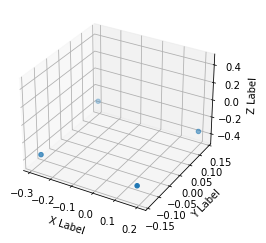

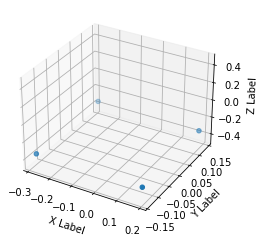

Footstep timestamp:  1630867790.5208204

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.177. FL_x (idx): 0.19. FL_y (idx+1): 0.138. FL_y (idx): 0.136
RR_x (idx+1): -0.294. RR_x (idx): -0.28. RR_y (idx+1): -0.138. RR_y (idx): -0.137
FR moving: True. Velocity: 0.1. FL_x movement: -0.013000000000000012. FL_y movement: 0.0020000000000000018. RR_x movement: -0.013999999999999957. RR_y movement: -0.0010000000000000009


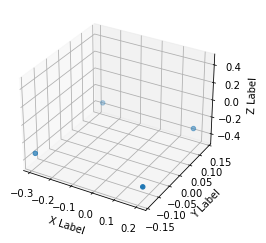

Footstep timestamp:  1630867790.726873

FL moving: True. FR moving: False
RL moving: False. RR moving: True
FR_x (idx+1): 0.179. FR_x (idx): 0.207. FR_y (idx+1): -0.138. FR_y (idx): -0.136
RL_x (idx+1): -0.295. RL_x (idx): -0.269. RL_y (idx+1): 0.137. RL_y (idx): 0.137
FL moving: True. Velocity: 0.1. FR_x movement: -0.027999999999999997. FR_y movement: -0.0020000000000000018. RL_x movement: -0.025999999999999968. RL_y movement: 0.0


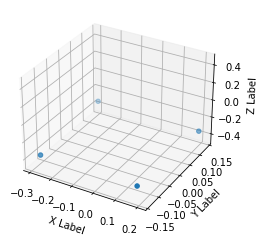

Footstep timestamp:  1630867791.0708678

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.173. FL_x (idx): 0.202. FL_y (idx+1): 0.137. FL_y (idx): 0.132
RR_x (idx+1): -0.294. RR_x (idx): -0.272. RR_y (idx+1): -0.137. RR_y (idx): -0.136
FR moving: True. Velocity: 0.1. FL_x movement: -0.029000000000000026. FL_y movement: 0.0050000000000000044. RR_x movement: -0.021999999999999964. RR_y movement: -0.0010000000000000009


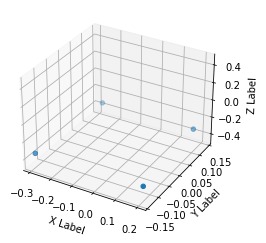

Footstep timestamp:  1630867791.366238

FL moving: True. FR moving: False
RL moving: False. RR moving: True
FR_x (idx+1): 0.184. FR_x (idx): 0.202. FR_y (idx+1): -0.145. FR_y (idx): -0.133
RL_x (idx+1): -0.279. RL_x (idx): -0.272. RL_y (idx+1): 0.145. RL_y (idx): 0.138
FL moving: True. Velocity: 0.1. FR_x movement: -0.018000000000000016. FR_y movement: -0.011999999999999983. RL_x movement: -0.007000000000000006. RL_y movement: 0.0069999999999999785


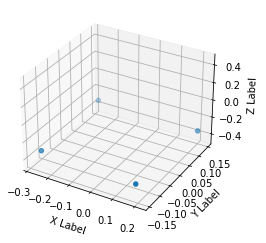

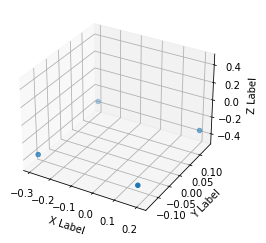

Footstep timestamp:  1630867792.8737712

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.177. FL_x (idx): 0.205. FL_y (idx+1): 0.137. FL_y (idx): 0.135
RR_x (idx+1): -0.306. RR_x (idx): -0.279. RR_y (idx+1): -0.136. RR_y (idx): -0.136
FR moving: True. Velocity: 0.1. FL_x movement: -0.027999999999999997. FL_y movement: 0.0020000000000000018. RR_x movement: -0.02699999999999997. RR_y movement: 0.0


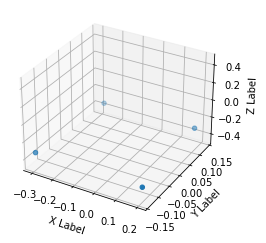

Footstep timestamp:  1630867793.1707332

FL moving: True. FR moving: False
RL moving: False. RR moving: True
FR_x (idx+1): 0.179. FR_x (idx): 0.202. FR_y (idx+1): -0.138. FR_y (idx): -0.137
RL_x (idx+1): -0.295. RL_x (idx): -0.274. RL_y (idx+1): 0.137. RL_y (idx): 0.136
FL moving: True. Velocity: 0.1. FR_x movement: -0.02300000000000002. FR_y movement: -0.0010000000000000009. RL_x movement: -0.020999999999999963. RL_y movement: 0.0010000000000000009


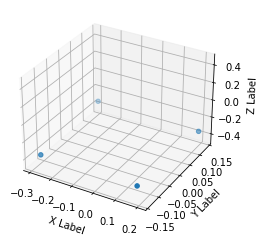

Footstep timestamp:  1630867793.4260428

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.172. FL_x (idx): 0.202. FL_y (idx+1): 0.138. FL_y (idx): 0.131
RR_x (idx+1): -0.294. RR_x (idx): -0.272. RR_y (idx+1): -0.136. RR_y (idx): -0.135
FR moving: True. Velocity: 0.1. FL_x movement: -0.030000000000000027. FL_y movement: 0.007000000000000006. RR_x movement: -0.021999999999999964. RR_y movement: -0.0010000000000000009


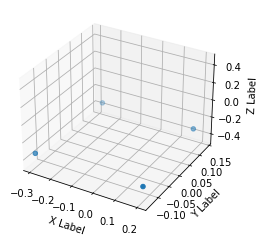

Footstep timestamp:  1630867793.8093386

FL moving: True. FR moving: False
RL moving: False. RR moving: True
FR_x (idx+1): 0.179. FR_x (idx): 0.202. FR_y (idx+1): -0.137. FR_y (idx): -0.133
RL_x (idx+1): -0.292. RL_x (idx): -0.272. RL_y (idx+1): 0.137. RL_y (idx): 0.138
FL moving: True. Velocity: 0.1. FR_x movement: -0.02300000000000002. FR_y movement: -0.0040000000000000036. RL_x movement: -0.019999999999999962. RL_y movement: -0.0010000000000000009


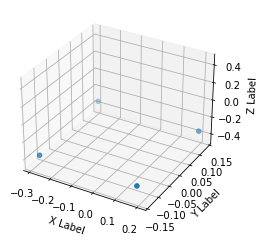

Footstep timestamp:  1630867794.1105745

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.169. FL_x (idx): 0.203. FL_y (idx+1): 0.136. FL_y (idx): 0.132
RR_x (idx+1): -0.301. RR_x (idx): -0.271. RR_y (idx+1): -0.136. RR_y (idx): -0.137
FR moving: True. Velocity: 0.1. FL_x movement: -0.034. FL_y movement: 0.0040000000000000036. RR_x movement: -0.02999999999999997. RR_y movement: 0.0010000000000000009


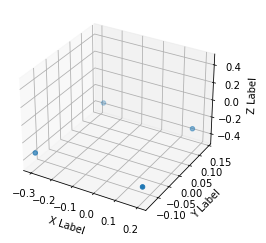

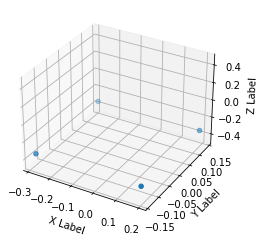

Footstep timestamp:  1630867795.8059103

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.181. FL_x (idx): 0.196. FL_y (idx+1): 0.139. FL_y (idx): 0.137
RR_x (idx+1): -0.297. RR_x (idx): -0.283. RR_y (idx+1): -0.138. RR_y (idx): -0.138
FR moving: True. Velocity: 0.1. FL_x movement: -0.015000000000000013. FL_y movement: 0.0020000000000000018. RR_x movement: -0.014000000000000012. RR_y movement: 0.0


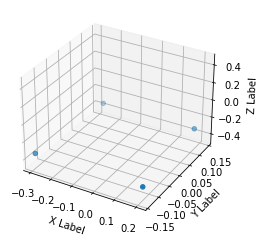

Footstep timestamp:  1630867796.0229936

FL moving: True. FR moving: False
RL moving: False. RR moving: True
FR_x (idx+1): 0.179. FR_x (idx): 0.207. FR_y (idx+1): -0.137. FR_y (idx): -0.136
RL_x (idx+1): -0.295. RL_x (idx): -0.268. RL_y (idx+1): 0.137. RL_y (idx): 0.137
FL moving: True. Velocity: 0.1. FR_x movement: -0.027999999999999997. FR_y movement: -0.0010000000000000009. RL_x movement: -0.02699999999999997. RL_y movement: 0.0


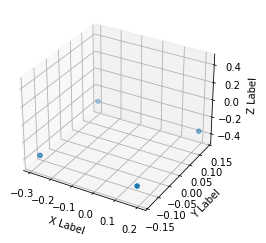

Footstep timestamp:  1630867796.3660007

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.178. FL_x (idx): 0.202. FL_y (idx+1): 0.141. FL_y (idx): 0.132
RR_x (idx+1): -0.289. RR_x (idx): -0.272. RR_y (idx+1): -0.14. RR_y (idx): -0.137
FR moving: True. Velocity: 0.1. FL_x movement: -0.02400000000000002. FL_y movement: 0.00899999999999998. RR_x movement: -0.01699999999999996. RR_y movement: -0.0030000000000000027


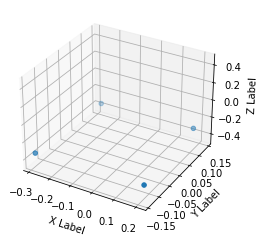

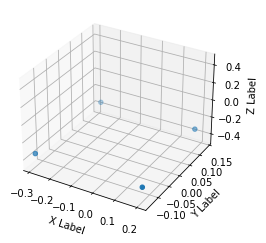

Footstep timestamp:  1630867797.8954387

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.174. FL_x (idx): 0.181. FL_y (idx+1): 0.137. FL_y (idx): 0.136
RR_x (idx+1): -0.296. RR_x (idx): -0.291. RR_y (idx+1): -0.137. RR_y (idx): -0.136
FR moving: True. Velocity: 0.1. FL_x movement: -0.007000000000000006. FL_y movement: 0.0010000000000000009. RR_x movement: -0.0050000000000000044. RR_y movement: -0.0010000000000000009


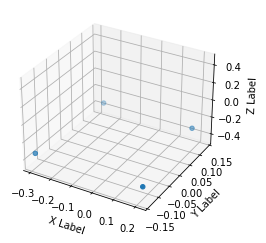

Footstep timestamp:  1630867798.1049302

FL moving: True. FR moving: False
RL moving: False. RR moving: True
FR_x (idx+1): 0.173. FR_x (idx): 0.211. FR_y (idx+1): -0.137. FR_y (idx): -0.135
RL_x (idx+1): -0.302. RL_x (idx): -0.267. RL_y (idx+1): 0.137. RL_y (idx): 0.137
FL moving: True. Velocity: 0.1. FR_x movement: -0.038000000000000006. FR_y movement: -0.0020000000000000018. RL_x movement: -0.034999999999999976. RL_y movement: 0.0


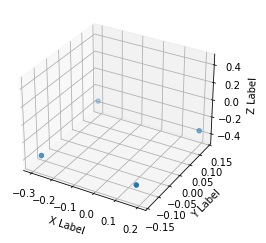

Footstep timestamp:  1630867798.489655

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.174. FL_x (idx): 0.201. FL_y (idx+1): 0.138. FL_y (idx): 0.134
RR_x (idx+1): -0.294. RR_x (idx): -0.272. RR_y (idx+1): -0.137. RR_y (idx): -0.138
FR moving: True. Velocity: 0.1. FL_x movement: -0.027000000000000024. FL_y movement: 0.0040000000000000036. RR_x movement: -0.021999999999999964. RR_y movement: 0.0010000000000000009


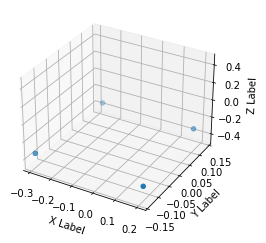

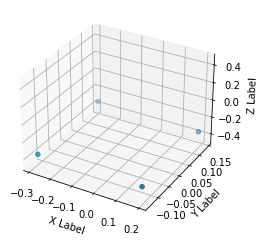

Footstep timestamp:  1630867800.1746776

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.174. FL_x (idx): 0.195. FL_y (idx+1): 0.136. FL_y (idx): 0.132
RR_x (idx+1): -0.302. RR_x (idx): -0.279. RR_y (idx+1): -0.136. RR_y (idx): -0.136
FR moving: True. Velocity: 0.1. FL_x movement: -0.02100000000000002. FL_y movement: 0.0040000000000000036. RR_x movement: -0.022999999999999965. RR_y movement: 0.0


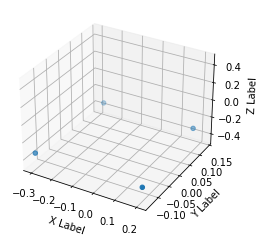

Footstep timestamp:  1630867800.4303687

FL moving: True. FR moving: False
RL moving: False. RR moving: True
FR_x (idx+1): 0.179. FR_x (idx): 0.205. FR_y (idx+1): -0.139. FR_y (idx): -0.136
RL_x (idx+1): -0.295. RL_x (idx): -0.273. RL_y (idx+1): 0.138. RL_y (idx): 0.137
FL moving: True. Velocity: 0.1. FR_x movement: -0.025999999999999995. FR_y movement: -0.0030000000000000027. RL_x movement: -0.021999999999999964. RL_y movement: 0.0010000000000000009


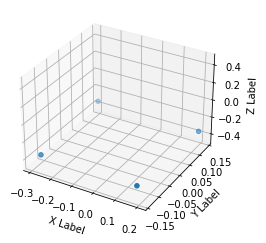

Footstep timestamp:  1630867800.7419972

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.173. FL_x (idx): 0.203. FL_y (idx+1): 0.138. FL_y (idx): 0.132
RR_x (idx+1): -0.294. RR_x (idx): -0.271. RR_y (idx+1): -0.137. RR_y (idx): -0.136
FR moving: True. Velocity: 0.1. FL_x movement: -0.030000000000000027. FL_y movement: 0.006000000000000005. RR_x movement: -0.022999999999999965. RR_y movement: -0.0010000000000000009


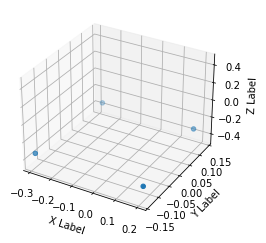

Footstep timestamp:  1630867801.0904024

FL moving: True. FR moving: False
RL moving: False. RR moving: True
FR_x (idx+1): 0.17. FR_x (idx): 0.202. FR_y (idx+1): -0.136. FR_y (idx): -0.133
RL_x (idx+1): -0.302. RL_x (idx): -0.272. RL_y (idx+1): 0.136. RL_y (idx): 0.138
FL moving: True. Velocity: 0.1. FR_x movement: -0.032. FR_y movement: -0.0030000000000000027. RL_x movement: -0.02999999999999997. RL_y movement: -0.0020000000000000018


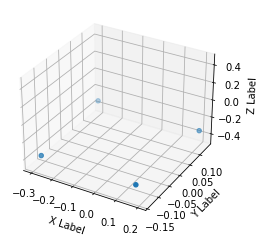

Footstep timestamp:  1630867801.4393032

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.17. FL_x (idx): 0.2. FL_y (idx+1): 0.137. FL_y (idx): 0.133
RR_x (idx+1): -0.299. RR_x (idx): -0.273. RR_y (idx+1): -0.136. RR_y (idx): -0.137
FR moving: True. Velocity: 0.1. FL_x movement: -0.03. FL_y movement: 0.0040000000000000036. RR_x movement: -0.025999999999999968. RR_y movement: 0.0010000000000000009


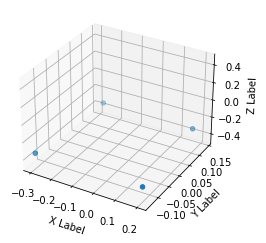

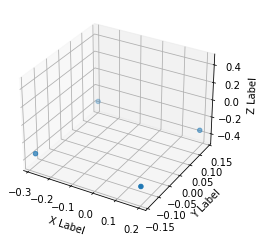

Footstep timestamp:  1630867803.1536121

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.175. FL_x (idx): 0.196. FL_y (idx+1): 0.137. FL_y (idx): 0.137
RR_x (idx+1): -0.304. RR_x (idx): -0.284. RR_y (idx+1): -0.137. RR_y (idx): -0.138
FR moving: True. Velocity: 0.1. FL_x movement: -0.02100000000000002. FL_y movement: 0.0. RR_x movement: -0.020000000000000018. RR_y movement: 0.0010000000000000009


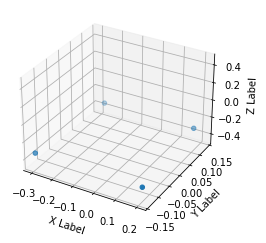

Footstep timestamp:  1630867803.3709047

FL moving: True. FR moving: False
RL moving: False. RR moving: True
FR_x (idx+1): 0.173. FR_x (idx): 0.204. FR_y (idx+1): -0.136. FR_y (idx): -0.137
RL_x (idx+1): -0.302. RL_x (idx): -0.271. RL_y (idx+1): 0.136. RL_y (idx): 0.137
FL moving: True. Velocity: 0.1. FR_x movement: -0.031. FR_y movement: 0.0010000000000000009. RL_x movement: -0.030999999999999972. RL_y movement: -0.0010000000000000009


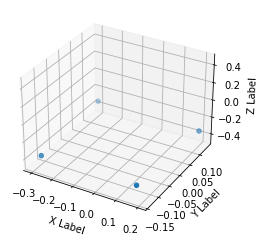

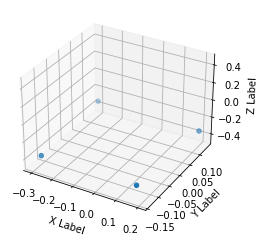

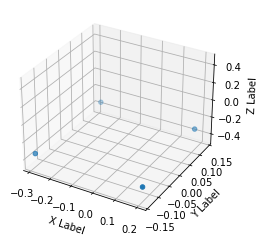

Footstep timestamp:  1630867805.1751308

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.168. FL_x (idx): 0.18. FL_y (idx+1): 0.135. FL_y (idx): 0.136
RR_x (idx+1): -0.305. RR_x (idx): -0.291. RR_y (idx+1): -0.135. RR_y (idx): -0.137
FR moving: True. Velocity: 0.1. FL_x movement: -0.011999999999999983. FL_y movement: -0.0010000000000000009. RR_x movement: -0.014000000000000012. RR_y movement: 0.0020000000000000018


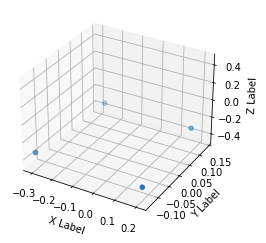

Footstep timestamp:  1630867805.4825592

FL moving: True. FR moving: False
RL moving: False. RR moving: True
FR_x (idx+1): 0.168. FR_x (idx): 0.207. FR_y (idx+1): -0.136. FR_y (idx): -0.136
RL_x (idx+1): -0.308. RL_x (idx): -0.27. RL_y (idx+1): 0.136. RL_y (idx): 0.138
FL moving: True. Velocity: 0.1. FR_x movement: -0.03899999999999998. FR_y movement: 0.0. RL_x movement: -0.03799999999999998. RL_y movement: -0.0020000000000000018


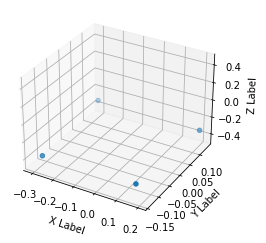

Footstep timestamp:  1630867805.7721984

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.171. FL_x (idx): 0.199. FL_y (idx+1): 0.137. FL_y (idx): 0.135
RR_x (idx+1): -0.298. RR_x (idx): -0.273. RR_y (idx+1): -0.136. RR_y (idx): -0.138
FR moving: True. Velocity: 0.1. FL_x movement: -0.027999999999999997. FL_y movement: 0.0020000000000000018. RR_x movement: -0.024999999999999967. RR_y movement: 0.0020000000000000018


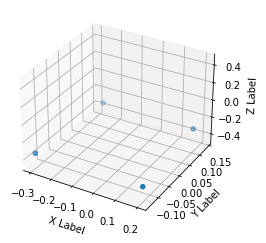

Footstep timestamp:  1630867806.1137016

FL moving: True. FR moving: False
RL moving: False. RR moving: True
FR_x (idx+1): 0.169. FR_x (idx): 0.201. FR_y (idx+1): -0.135. FR_y (idx): -0.134
RL_x (idx+1): -0.305. RL_x (idx): -0.272. RL_y (idx+1): 0.135. RL_y (idx): 0.138
FL moving: True. Velocity: 0.1. FR_x movement: -0.032. FR_y movement: -0.0010000000000000009. RL_x movement: -0.032999999999999974. RL_y movement: -0.0030000000000000027


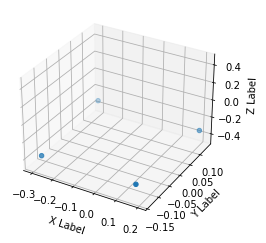

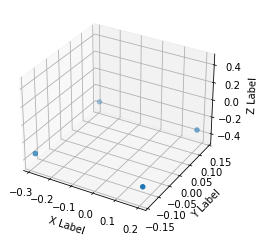

Footstep timestamp:  1630867807.8227391

FL moving: False. FR moving: True
RL moving: True. RR moving: False
FL_x (idx+1): 0.175. FL_x (idx): 0.188. FL_y (idx+1): 0.137. FL_y (idx): 0.136
RR_x (idx+1): -0.3. RR_x (idx): -0.289. RR_y (idx+1): -0.137. RR_y (idx): -0.138
FR moving: True. Velocity: 0.1. FL_x movement: -0.013000000000000012. FL_y movement: 0.0010000000000000009. RR_x movement: -0.01100000000000001. RR_y movement: 0.0010000000000000009


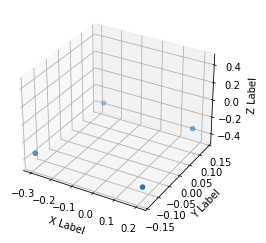

Footstep timestamp:  1630867808.0226583

FL moving: True. FR moving: False
RL moving: False. RR moving: True
FR_x (idx+1): 0.17310619354248047. FR_x (idx): 0.208. FR_y (idx+1): -0.13696320354938507. FR_y (idx): -0.136
RL_x (idx+1): -0.3018108606338501. RL_x (idx): -0.27. RL_y (idx+1): 0.1369679570198059. RL_y (idx): 0.138
FL moving: True. Velocity: 0.1. FR_x movement: -0.03489380645751952. FR_y movement: -0.000963203549385061. RL_x movement: -0.03181086063385008. RL_y movement: -0.0010320429801941033


KeyboardInterrupt: 

In [23]:
def visualize_absolute_foostep_sizes(dataset, footsteps, threshold=0.02):
    # Visualize footsteps
    for idx, footstep in enumerate(footsteps):
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

        #ax.set_xlim([-0.5, 0.5])
        #ax.set_ylim([-0.3, 0.3])
        ax.set_zlim([-0.5, 0.5])

        dataset[footstep, 7:19] = np.round(dataset[footstep, 7:19], 3)
                    
        # 3D positions
        xs = np.array([dataset[footstep, 7], dataset[footstep, 10], dataset[footstep, 13], dataset[footstep, 16]])
        ys = np.array([dataset[footstep, 8], dataset[footstep, 11], dataset[footstep, 14], dataset[footstep, 17]])
        zs = np.array([dataset[footstep, 9], dataset[footstep, 12], dataset[footstep, 15], dataset[footstep, 18]])

        ax.scatter(xs, ys, zs, marker='o')

        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        
        plt.show()
        
        if idx < (len(footsteps) - 1):
            time_difference = abs(dataset[footsteps[idx], 0] - dataset[footsteps[idx+1], 0])
            
            if time_difference < 0.4 and time_difference > 0:
                # Find corresponding index between two consecutive footsteps
                lower_bound_index = np.abs(dataset[:, 0] - (dataset[footsteps[idx], 0]))
                upper_bound_index = np.abs(dataset[:, 0] - (dataset[footsteps[idx], 0] + time_difference))
                matching_index_lower_bound = lower_bound_index.argmin()
                matching_index_upper_bound = upper_bound_index.argmin()

                # Retrieve what is the maximum height
                # reached in between the current and
                # next footstep
                height_peeks_in_between = [dataset[matching_index_lower_bound:matching_index_upper_bound, x] for x in [9, 12, 15, 18]]

                fl_moving = max(height_peeks_in_between[0]) > -0.31
                fr_moving = max(height_peeks_in_between[1]) > -0.31
                rl_moving = max(height_peeks_in_between[2]) > -0.31
                rr_moving = max(height_peeks_in_between[3]) > -0.31
                
                print("Footstep timestamp: ", dataset[footstep, 0])
                print(f'\nFL moving: {fl_moving}. FR moving: {fr_moving}')
                print(f'RL moving: {rl_moving}. RR moving: {rr_moving}')

                #assert (fr_moving > threshold) == (rl_moving > threshold)
                #assert (rr_moving > threshold) == (fl_moving > threshold)
                #assert (fr_moving > threshold) != (fl_moving > threshold)

                # Compute FR movement
                fl_movement_x = dataset[footsteps[idx+1], 7] - dataset[footstep, 7]
                fl_movement_y = dataset[footsteps[idx+1], 8] - dataset[footstep, 8]

                # Compute FL movement
                fr_movement_x = dataset[footsteps[idx+1], 10] - dataset[footstep, 10]
                fr_movement_y = dataset[footsteps[idx+1], 11] - dataset[footstep, 11]

                # Compute RR movement
                rl_movement_x = dataset[footsteps[idx+1], 13] - dataset[footstep, 13]
                rl_movement_y = dataset[footsteps[idx+1], 14] - dataset[footstep, 14]

                # Compute RL movement
                rr_movement_x = dataset[footsteps[idx+1], 16] - dataset[footstep, 16]
                rr_movement_y = dataset[footsteps[idx+1], 17] - dataset[footstep, 17
                
                if (not fr_moving != fl_moving):
                    print("Exception")
                    print(idx, height_peeks_in_between)
                    print("Time difference: ", time_difference)
                    print("Footstep timestamp: ", dataset[footstep, 0])
                    print(f'FL moving: {fl_moving}. FR moving: {fr_moving}')
                    print(f'RL moving: {rl_moving}. RR moving: {rr_moving}')
                    continue

                if fr_moving:
                    #print(f'Odom_x (idx+1): {dataset[footsteps[idx+1], 31]}. Odom_x (idx): {dataset[footsteps[idx], 31]}. Odom_x displacement: {dataset[footsteps[idx+1], 31] - dataset[footsteps[idx], 31]}')
                    #print(f'Odom_y (idx+1): {dataset[footsteps[idx+1], 32]}. Odom_y (idx): {dataset[footsteps[idx], 32]}. Odom_y displacement: {dataset[footsteps[idx+1], 32] - dataset[footsteps[idx], 32]}')
                    print(f'FL_x (idx+1): {dataset[footsteps[idx+1], 7]}. FL_x (idx): {dataset[footstep, 7]}. FL_y (idx+1): {dataset[footsteps[idx+1], 8]}. FL_y (idx): {dataset[footstep, 8]}')
                    print(f'RR_x (idx+1): {dataset[footsteps[idx+1], 16]}. RR_x (idx): {dataset[footstep, 16]}. RR_y (idx+1): {dataset[footsteps[idx+1], 17]}. RR_y (idx): {dataset[footstep, 17]}')
                    print(f'FR moving: {fr_moving}. Velocity: {dataset[footstep, 1]}. FL_x movement: {fl_movement_x}. FL_y movement: {fl_movement_y}. RR_x movement: {rr_movement_x}. RR_y movement: {rr_movement_y}')
                else:
                    #print(f'Odom_x (idx+1): {dataset[footsteps[idx+1], 31]}. Odom_x (idx): {dataset[footsteps[idx], 31]}. Odom_x displacement: {dataset[footsteps[idx+1], 31] - dataset[footsteps[idx], 31]}')
                    #print(f'Odom_y (idx+1): {dataset[footsteps[idx+1], 32]}. Odom_y (idx): {dataset[footsteps[idx], 32]}. Odom_y displacement: {dataset[footsteps[idx+1], 32] - dataset[footsteps[idx], 32]}')
                    print(f'FR_x (idx+1): {dataset[footsteps[idx+1], 10]}. FR_x (idx): {dataset[footstep, 10]}. FR_y (idx+1): {dataset[footsteps[idx+1], 11]}. FR_y (idx): {dataset[footstep, 11]}')
                    print(f'RL_x (idx+1): {dataset[footsteps[idx+1], 13]}. RL_x (idx): {dataset[footstep, 13]}. RL_y (idx+1): {dataset[footsteps[idx+1], 14]}. RL_y (idx): {dataset[footstep, 14]}')
                    print(f'FL moving: {fl_moving}. Velocity: {dataset[footstep, 1]}. FR_x movement: {fr_movement_x}. FR_y movement: {fr_movement_y}. RL_x movement: {rl_movement_x}. RL_y movement: {rl_movement_y}')

                #print(f'\nCoord FL: {[xs[0], ys[0], zs[0]]}. Coord FR: {[xs[1], ys[1], zs[1]]}. Coord RL: {[xs[2], ys[2], zs[2]]}. Coord RR: {[xs[3], ys[3], zs[3]]}')

                #if fr_moving:
                #    print(f'\nFR step_size x: {fr_movement_x + fl_movement_x}. FR step_size y: {fr_movement_y + fl_movement_y}. RL step_size x: {rl_movement_x + rr_movement_x}. RL step_size x: {rl_movement_y + rr_movement_y}.')
                #elif fl_moving:
                #    print(f'\nFL step_size x: {fr_movement_x + fl_movement_x}. FL step_size y: {fr_movement_y + fl_movement_y}. RR step_size x: {rl_movement_x + rr_movement_x}. RR step_size x: {rl_movement_y + rr_movement_y}.')
                #else:
                #    print("\nERROR")

visualize_absolute_foostep_sizes(motion_01_fwd, footsteps_01_fwd, threshold=0.01)                  

### Forward motion

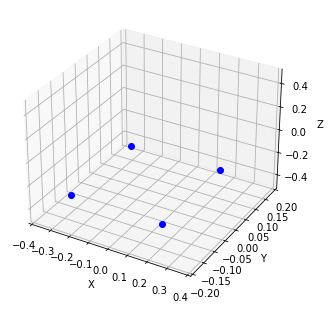

In [53]:
anim = visualize_animated_footsteps(motion_01_fwd, footsteps_01_fwd, "bo")
HTML(anim.to_html5_video())

### Backward motion

In [97]:
#anim = visualize_animated_footsteps(motion_01_bwd, footsteps_01_bwd, "bo")
#HTML(anim.to_html5_video())

### Side motion (right)

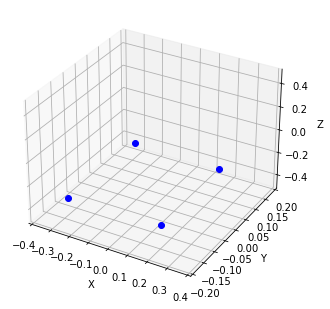

In [98]:
anim = visualize_animated_footsteps(motion_01_side_right, footsteps_01_side_right, "bo")
HTML(anim.to_html5_video())

### Side motion (left)

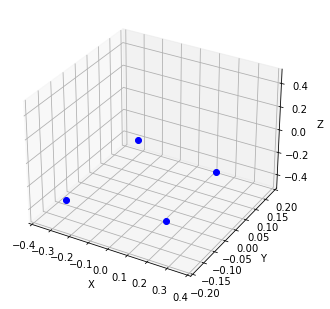

In [99]:
anim = visualize_animated_footsteps(motion_01_side_left, footsteps_01_side_left, "bo")
HTML(anim.to_html5_video())

### Rotation (clockwise)

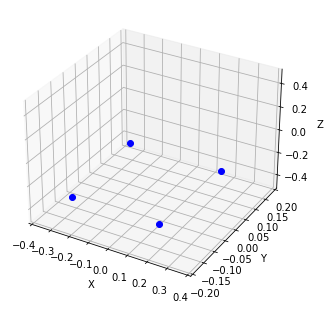

In [100]:
anim = visualize_animated_footsteps(motion_01_clock, footsteps_01_clock, "bo")
HTML(anim.to_html5_video())

### Rotation (counter clockwise)

CalledProcessError: Command '['/usr/bin/ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '432x288', '-pix_fmt', 'rgba', '-r', '5.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmp_defqofq/temp.m4v']' returned non-zero exit status 255.

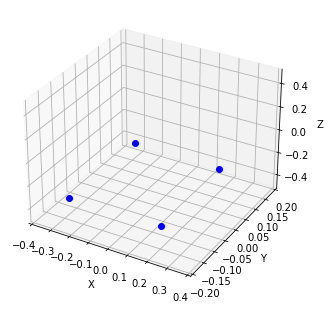

In [101]:
anim = visualize_animated_footsteps(motion_01_count, footsteps_01_count, "bo")
HTML(anim.to_html5_video())

# Multivariate Linear Regression (FR foot prediction)

The input will use initially only:

- **HighCmd: fwd, side, rot speeds**
- **HighState: fwd, side, rot speeds, footPosition2Body (FR)**

and as output we seek to predict the following:

- **footPosition2Body (FR)**

In [87]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [88]:
def plot_target_and_predictions(title: str, predictions, target):
    fig, ax1 = plt.subplots(1,1, figsize=(15,10))
    fig.suptitle(title)
    
    # FR plot (height)
    ax1.plot(range(predictions.shape[0]), predictions, 'b-')
    ax1.set_ylabel('Predictions')
    ax1.set_xlabel('Time')
         
    # FR plot (force)
    ax2 = ax1.twinx()
    ax2.plot(range(predictions.shape[0]), target, 'g-')
    ax2.set_ylabel('Target', color='g')

    for tl in ax2.get_yticklabels():
        tl.set_color('g')
    
    fig.tight_layout()
    plt.show()

In [90]:
def create_timestamp_consistent_dataset(dataset, footsteps):
    # Footsteps sizes
    inputs = []
    labels = []
        
    # Compute step sizes
    for idx, footstep in enumerate(footsteps):
        if idx > 0:
            time_diff = dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0]
            
            if time_diff < 1.0:
                inputs.append(dataset[footsteps[idx-1], 1:7].tolist() + dataset[footsteps[idx-1], 7:19].tolist())
                labels.append(dataset[footsteps[idx], 7:19])
            else:
                continue
                    
    # Convert to numpy array
    inputs_numpy = np.array(inputs)
    labels_numpy = np.array(labels)
    
    return inputs_numpy, labels_numpy

X_motion_01_fwd_3D, Y_motion_01_fwd_3D = create_timestamp_consistent_dataset(motion_01_fwd, footsteps_01_fwd)
#X_motion_01_bwd_3D, Y_motion_01_bwd_3D = create_timestamp_consistent_dataset(motion_01_bwd, footsteps_01_bwd)
#X_motion_01_clock_3D, Y_motion_01_clock_3D = create_timestamp_consistent_dataset(motion_01_clock, footsteps_01_clock)
#X_motion_01_count_3D, Y_motion_01_count_3D = create_timestamp_consistent_dataset(motion_01_count, footsteps_01_count)
#X_motion_01_side_left_3D, Y_motion_01_side_left_3D = create_timestamp_consistent_dataset(motion_01_side_left, footsteps_01_side_left)
#X_motion_01_side_right_3D, Y_motion_01_side_right_3D = create_timestamp_consistent_dataset(motion_01_side_right, footsteps_01_side_right)

# Stack datasets
#X_motion_01_3D = np.concatenate((X_motion_01_fwd_3D, X_motion_01_bwd_3D, X_motion_01_side_right_3D, X_motion_01_side_left_3D, X_motion_01_clock_3D, X_motion_01_count_3D))
#Y_motion_01_3D = np.concatenate((Y_motion_01_fwd_3D, Y_motion_01_bwd_3D, Y_motion_01_side_right_3D, Y_motion_01_side_left_3D, Y_motion_01_clock_3D, Y_motion_01_count_3D))

In [91]:
for x in range(10):
    print(X_motion_01_fwd_3D[x, 6:9], ", ", Y_motion_01_fwd_3D[x, :3])

[ 0.183  0.137 -0.338] ,  [ 0.17   0.136 -0.334]
[ 0.17   0.136 -0.334] ,  [ 0.202  0.133 -0.337]
[ 0.202  0.133 -0.337] ,  [ 0.174  0.138 -0.342]
[ 0.174  0.138 -0.342] ,  [ 0.202  0.131 -0.337]
[ 0.202  0.131 -0.337] ,  [ 0.174  0.138 -0.342]
[ 0.204  0.136 -0.338] ,  [ 0.184  0.139 -0.339]
[ 0.184  0.139 -0.339] ,  [ 0.199  0.131 -0.335]
[ 0.199  0.131 -0.335] ,  [ 0.169  0.136 -0.339]
[ 0.169  0.136 -0.339] ,  [ 0.203  0.132 -0.338]
[ 0.203  0.132 -0.338] ,  [ 0.168  0.136 -0.335]


In [51]:
%store X_motion_01_3D
%store Y_motion_01_3D

Stored 'X_motion_01_3D' (ndarray)
Stored 'Y_motion_01_3D' (ndarray)


In [52]:
def create_timestamp_consistent_dataset_with_step_size_labels(dataset, footsteps, threshold=0.02):
    # Footsteps sizes
    inputs = []
    labels = []
            
    # Compute step sizes
    for idx, footstep in enumerate(footsteps):
        if idx < (len(footsteps) - 1):
            time_diff = abs(dataset[footsteps[idx], 0] - dataset[footsteps[idx+1], 0])
            
            if time_diff < 1.0:
                
                # Find closest timestamp with gap of 0.12 (to know which foot is moving)
                absolute_val_array = np.abs(dataset[:, 0] - (dataset[footstep, 0] + 0.12))
                idx_height_check = absolute_val_array.argmin()
                
                fl_moving = np.abs(dataset[footstep, 9] - dataset[idx_height_check, 9]) > threshold
                fr_moving = np.abs(dataset[footstep, 12] - dataset[idx_height_check, 12]) > threshold
                rl_moving = np.abs(dataset[footstep, 15] - dataset[idx_height_check, 15]) > threshold
                rr_moving = np.abs(dataset[footstep, 18] - dataset[idx_height_check, 18]) > threshold

                valid_1 = (fr_moving > threshold) == (rl_moving > threshold)
                valid_2 = (rr_moving > threshold) == (fl_moving > threshold)
                valid_3 = (fr_moving > threshold) != (fl_moving > threshold)

                if (not valid_1 or not valid_2 or not valid_3):
                    print("Skipping idx: ", idx, " as flags not valid")
                    continue
                
                # Compute FL movement
                fl_movement_x = abs(abs(dataset[footstep, 7]) - abs(dataset[footsteps[idx+1], 7]))
                fl_movement_y = abs(abs(dataset[footstep, 8]) - abs(dataset[footsteps[idx+1], 8]))

                # Compute FR movement
                fr_movement_x = abs(abs(dataset[footstep, 10]) - abs(dataset[footsteps[idx+1], 10]))
                fr_movement_y = abs(abs(dataset[footstep, 11]) - abs(dataset[footsteps[idx+1], 11]))

                # Compute RL movement
                rl_movement_x = abs(abs(dataset[footstep, 13]) - abs(dataset[footsteps[idx+1], 13]))
                rl_movement_y = abs(abs(dataset[footstep, 14]) - abs(dataset[footsteps[idx+1], 14]))

                # Compute RR movement
                rr_movement_x = abs(abs(dataset[footstep, 16]) - abs(dataset[footsteps[idx+1], 16]))
                rr_movement_y = abs(abs(dataset[footstep, 17]) - abs(dataset[footsteps[idx+1], 17]))
                
                # Compute new feet position w.r.t old centre of mass
                fl_x = dataset[footstep, 7] + (fr_movement_x + fl_movement_x)
                fl_y = dataset[footstep, 8] + (fr_movement_y + fl_movement_y)
                fr_x = dataset[footstep, 10] + (fr_movement_x + fl_movement_x)
                fr_y = dataset[footstep, 11] + (fr_movement_y + fl_movement_y)
                rl_x = dataset[footstep, 13] + (rr_movement_x + rl_movement_x)
                rl_y = dataset[footstep, 14] + (rr_movement_y + rl_movement_y)
                rr_x = dataset[footstep, 16] + (rr_movement_x + rl_movement_x)
                rr_y = dataset[footstep, 17] + (rr_movement_y + rl_movement_y)

                label = []

                if fr_moving:
                    label.append([dataset[footstep, 7], dataset[footstep, 8], fr_x, fr_y, rl_x, rl_y, dataset[footstep, 16], dataset[footstep, 17]])
                elif fl_moving:
                    label.append([fl_x, fl_y, dataset[footstep, 10], dataset[footstep, 11], dataset[footstep, 13], dataset[footstep, 14], rr_x, rr_y])
                else:
                    print("\nERROR")

                labels.append(label)
                inputs.append(dataset[footsteps[idx-1], 1:7].tolist() + dataset[footsteps[idx-1], 7:19].tolist())
                    
    # Convert to numpy array
    inputs_numpy = np.array(inputs)
    labels_numpy = np.array(labels)
    
    return inputs_numpy, labels_numpy.reshape(labels_numpy.shape[0], labels_numpy.shape[2])

X_motion_01_fwd_step, Y_motion_01_fwd_step = create_timestamp_consistent_dataset_with_step_size_labels(motion_01_fwd, footsteps_01_fwd)
X_motion_01_bwd_step, Y_motion_01_bwd_step = create_timestamp_consistent_dataset_with_step_size_labels(motion_01_bwd, footsteps_01_bwd)
X_motion_01_clock_step, Y_motion_01_clock_step = create_timestamp_consistent_dataset_with_step_size_labels(motion_01_clock, footsteps_01_clock)
X_motion_01_count_step, Y_motion_01_count_step = create_timestamp_consistent_dataset_with_step_size_labels(motion_01_count, footsteps_01_count)
X_motion_01_side_left_step, Y_motion_01_side_left_step = create_timestamp_consistent_dataset_with_step_size_labels(motion_01_side_left, footsteps_01_side_left)
X_motion_01_side_right_step, Y_motion_01_side_right_step = create_timestamp_consistent_dataset_with_step_size_labels(motion_01_side_right, footsteps_01_side_right)

# Stack datasets
X_motion_01_step = np.concatenate((X_motion_01_fwd_step, X_motion_01_bwd_step, X_motion_01_side_right_step, X_motion_01_side_left_step, X_motion_01_clock_step, X_motion_01_count_step))
Y_motion_01_step = np.concatenate((Y_motion_01_fwd_step, Y_motion_01_bwd_step, Y_motion_01_side_right_step, Y_motion_01_side_left_step, Y_motion_01_clock_step, Y_motion_01_count_step))

In [53]:
%store X_motion_01_step
%store Y_motion_01_step

Stored 'X_motion_01_step' (ndarray)
Stored 'Y_motion_01_step' (ndarray)


In [54]:
def labels_stats(dataset, title):
    print(f'Statistics for {title} motion\n')
    
    # Find all positive movements in x and y for FR
    fr_steps_x = np.where(dataset[:, 0] > 0)[0]
    fr_steps_y = np.where(dataset[:, 1] > 0)[0]
    
    # Find all positive movements in x and y for FR
    fl_steps_x = np.where(dataset[:, 2] > 0)[0]
    fl_steps_y = np.where(dataset[:, 3] > 0)[0]
    
    # Find all positive movements in x and y for FR
    rr_steps_x = np.where(dataset[:, 4] > 0)[0]
    rr_steps_y = np.where(dataset[:, 5] > 0)[0]
    
    # Find all positive movements in x and y for FR
    rl_steps_x = np.where(dataset[:, 6] > 0)[0]
    rl_steps_y = np.where(dataset[:, 7] > 0)[0]
    
    # Compute stats for FR foot
    print(f'FR mean x step: {np.mean(dataset[fr_steps_x, 0])}. FR std x step: {np.std(dataset[fr_steps_x, 0])}. FR mean y step: {np.mean(dataset[fr_steps_y, 1])}. FR std y step: {np.std(dataset[fr_steps_y, 1])}')
 
    # Compute stats for FL foot
    print(f'FL mean x step: {np.mean(dataset[fl_steps_x, 2])}. FL std x step: {np.std(dataset[fl_steps_x, 2])}. FL mean y step: {np.mean(dataset[fl_steps_y, 3])}. FL std y step: {np.std(dataset[fl_steps_y, 3])}')
    
    # Compute stats for RR foot
    print(f'RR mean x step: {np.mean(dataset[rr_steps_x, 4])}. RR std x step: {np.std(dataset[rr_steps_x, 4])}. RR mean y step: {np.mean(dataset[rr_steps_y, 5])}. RR std y step: {np.std(dataset[rr_steps_y, 5])}')
    
    # Compute stats for RL foot
    print(f'RL mean x step: {np.mean(dataset[rl_steps_x, 6])}. RL std x step: {np.std(dataset[rl_steps_x, 6])}. RL mean y step: {np.mean(dataset[rl_steps_y, 7])}. RL std y step: {np.std(dataset[rl_steps_y, 7])}\n')
    
labels_stats(Y_motion_01_fwd_step, "forward")
labels_stats(Y_motion_01_bwd_step, "backward")
labels_stats(Y_motion_01_clock_step, "clockwise")
labels_stats(Y_motion_01_count_step, "counter clockwise")
labels_stats(Y_motion_01_side_left_step, "left step")
labels_stats(Y_motion_01_side_right_step, "right step")

Statistics for forward motion

FR mean x step: 0.2150166666666667. FR std x step: 0.013834528060857979. FR mean y step: 0.13842222222222225. FR std y step: 0.006220892715104447
FL mean x step: 0.21712222222222227. FL std x step: 0.015150231225061869. FL mean y step: nan. FL std y step: nan
RR mean x step: nan. RR std x step: nan. RR mean y step: 0.13861666666666667. RR std y step: 0.0008773381458834578
RL mean x step: nan. RL std x step: nan. RL mean y step: nan. RL std y step: nan

Statistics for backward motion

FR mean x step: 0.22858333333333336. FR std x step: 0.057131706997467224. FR mean y step: 0.1383777777777778. FR std y step: 0.005767876130927957
FL mean x step: 0.2265277777777778. FL std x step: 0.05407591685723524. FL mean y step: nan. FL std y step: nan
RR mean x step: nan. RR std x step: nan. RR mean y step: 0.13794444444444448. RR std y step: 0.0016456076966756168
RL mean x step: nan. RL std x step: nan. RL mean y step: nan. RL std y step: nan

Statistics for clockwise 

/home/itaouil/miniconda3/envs/pytorch-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/itaouil/miniconda3/envs/pytorch-env/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/itaouil/miniconda3/envs/pytorch-env/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/itaouil/miniconda3/envs/pytorch-env/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/itaouil/miniconda3/envs/pytorch-env/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [114]:
def getCoMDataset(dataset, footsteps):
    # Footsteps sizes
    inputs = []
    labels = []
            
    # Compute step sizes
    for idx, footstep in enumerate(footsteps):
        if idx < (len(footsteps) - 1):
            time_diff = abs(dataset[footsteps[idx], 0] - dataset[footsteps[idx+1], 0])
            #print(time_diff)
            
            if time_diff < 0.5:
                
                com_movement_x = abs(dataset[footsteps[idx+1], 31] - dataset[footstep, 31])
                com_movement_y = abs(dataset[footsteps[idx+1], 32] - dataset[footstep, 32])
                #print(dataset[footsteps[idx+1], 31], ", ", dataset[footstep, 31])

                labels.append([com_movement_x, com_movement_y])
                inputs.append(dataset[footsteps[idx-1], 1:7].tolist() + dataset[footsteps[idx-1], 7:19].tolist())
                    
    # Convert to numpy array
    inputs_numpy = np.array(inputs)
    labels_numpy = np.array(labels)
    
    return inputs_numpy, labels_numpy

X_motion_01_fwd_CoM_step, Y_motion_01_fwd_CoM_step = getCoMDataset(motion_01_fwd, footsteps_01_fwd)
#X_motion_01_bwd_CoM_step, Y_motion_01_bwd_CoM_step = getCoMDataset(motion_01_bwd, footsteps_01_bwd)
X_motion_01_clock_CoM_step, Y_motion_01_clock_CoM_step = getCoMDataset(motion_01_clock, footsteps_01_clock)
X_motion_01_count_CoM_step, Y_motion_01_count_CoM_step = getCoMDataset(motion_01_count, footsteps_01_count)
X_motion_01_side_left_CoM_step, Y_motion_01_side_left_CoM_step = getCoMDataset(motion_01_side_left, footsteps_01_side_left)
X_motion_01_side_right_CoM_step, Y_motion_01_side_right_CoM_step = getCoMDataset(motion_01_side_right, footsteps_01_side_right)

# Stack datasets
#X_motion_01_CoM_step = np.concatenate((X_motion_01_fwd_CoM_step, X_motion_01_bwd_CoM_step, X_motion_01_side_right_CoM_step, X_motion_01_side_left_CoM_step, X_motion_01_clock_CoM_step, X_motion_01_count_CoM_step))
#Y_motion_01_CoM_step = np.concatenate((Y_motion_01_fwd_CoM_step, Y_motion_01_bwd_CoM_step, Y_motion_01_side_right_CoM_step, Y_motion_01_side_left_CoM_step, Y_motion_01_clock_CoM_step, Y_motion_01_count_CoM_step))

In [100]:
%store X_motion_01_CoM_step
%store Y_motion_01_CoM_step

UsageError: Unknown variable 'X_motion_01_CoM_step'


In [115]:
def labels_stats(dataset, title):
    print(f'Statistics for {title} CoM motion')
    
    # Compute stats for FR foot
    print(f'CoM mean x step: {round(np.mean(dataset[:, 0]), 3)}. CoM mean y step: {round(np.mean(dataset[:, 1]), 3)}. CoM std x step: {round(np.std(dataset[:, 0]), 3)}. CoM std y step: {round(np.std(dataset[:, 1]), 3)}.\n')

labels_stats(Y_motion_01_fwd_CoM_step, "forward")
#labels_stats(Y_motion_01_bwd_CoM_step, "backward")
labels_stats(Y_motion_01_clock_CoM_step, "clockwise")
labels_stats(Y_motion_01_count_CoM_step, "counter clockwise")
labels_stats(Y_motion_01_side_left_CoM_step, "left step")
labels_stats(Y_motion_01_side_right_CoM_step, "right step")

Statistics for forward CoM motion
CoM mean x step: 0.015. CoM mean y step: 0.01. CoM std x step: 0.008. CoM std y step: 0.008.

Statistics for clockwise CoM motion
CoM mean x step: 0.006. CoM mean y step: 0.006. CoM std x step: 0.004. CoM std y step: 0.004.

Statistics for counter clockwise CoM motion
CoM mean x step: 0.006. CoM mean y step: 0.006. CoM std x step: 0.004. CoM std y step: 0.004.

Statistics for left step CoM motion
CoM mean x step: 0.019. CoM mean y step: 0.014. CoM std x step: 0.01. CoM std y step: 0.009.

Statistics for right step CoM motion
CoM mean x step: 0.009. CoM mean y step: 0.022. CoM std x step: 0.007. CoM std y step: 0.01.



In [ ]:
print(f'Rotation in rad for clockwise {np.arctan(np.mean(Y_motion_01_clock_CoM_step[:, 1]) / -np.mean(Y_motion_01_clock_CoM_step[:, 0]))}')
print(f'Rotation in angles for clockwise {np.arctan(np.mean(Y_motion_01_clock_CoM_step[:, 1]) / -np.mean(Y_motion_01_clock_CoM_step[:, 0])) * 180 / np.pi}')

In [ ]:
print(f'Rotation in rad for count {np.arctan(np.mean(Y_motion_01_count_CoM_step[:, 1]) / np.mean(Y_motion_01_count_CoM_step[:, 0]))}')
print(f'Rotation in angles for count {np.arctan(np.mean(Y_motion_01_count_CoM_step[:, 1]) / np.mean(Y_motion_01_count_CoM_step[:, 0])) * 180 / np.pi}')

In [ ]:
Y_motion_01_count_CoM_step[:, 0]